In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
#from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table

In [3]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

## Importing in 2014 Flares List

In [4]:
flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   'ED','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])

In [5]:
t_starts=flare_table.loc[:,'t_start']
t_stops=flare_table.loc[:,'t_stop']
flux_peak = flare_table.loc[:,'flux peak'].values
complex_flag = flare_table['Complex flag'] #2=complex, 1 = classical
ED = flare_table['ED'] #units=seconds
flare_table['Flare_Duration'] = 1440.*(t_stops-t_starts) #units = minutes

In [6]:
# Separating the types of flares
classical = len([i for i in complex_flag if i < 2.0]) 
print ("The number of classical flares : " + str(classical)) 

cmplx = len([i for i in complex_flag if i > 1.0]) 
print ("The number of complex flares : " + str(cmplx)) 

complex_flares = flare_table[flare_table['Complex flag'] == 2.0]
classical_flares = flare_table[flare_table['Complex flag'] == 1.0]

#-----------------------------------------------------------------------------------------
min_dur = 20.0 #minutes
max_dur = 75.0

dur_limit = len([i for i in flare_table['Flare_Duration'] if i >= min_dur and i<max_dur]) 
print ("The number of total flares with a duration between 20-75min : " + str(dur_limit))

#------------------------------------------------------------------------------------------
#adding in a column that is the flare duration into the table 
classical_flares['Flare_Duration'] = 1440.*(classical_flares['t_stop'] - classical_flares['t_start'])
#classical_flares

print (len([i for i in classical_flares['Flare_Duration'] if i >= min_dur and i < max_dur]))

#------------------------------------------------------------------------------------------

#Table of Classical flares that are between 20-75 minutes as defined in Davenport(2014)

timed_classical = classical_flares[(classical_flares['Flare_Duration'] >= min_dur) & (classical_flares['Flare_Duration'] < max_dur)]
print(len(timed_classical))

The number of classical flares : 5162
The number of complex flares : 945
The number of total flares with a duration between 20-75min : 1641
902
902


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Vetted Flares List

In [7]:
final_flares =pd.read_csv('/Users/lupitatovar/local_flares/notebooks/flare_diagnostics/final_flare_diagnostics.csv',
            names=["Flare_Number","Type","Notes",'na','key'],skiprows=1)
flag3 = pd.to_numeric(final_flares["Type"].values, errors='coerce')

In [8]:
#final_flares

In [9]:
# FINAL SET OF VETTED FLARES

final_classical = len([i for i in flag3 if i == 1.]) 
print ("The number of remaining classical flares : " + str(final_classical)) 

final_complex = len([i for i in flag3 if i == 3.]) 
print ("The number flares tossed out : " + str(final_complex)) 

final_edit = len([i for i in flag3 if i == 2.]) 
print ("The number of flares who need edited times : " + str(final_edit)) 


# Creating the data tables of newly classified flares (use these to make stacked flares plot)
final_edit_times = final_flares[final_flares["Type"].values == 2.]
final_toss = final_flares[final_flares["Type"].values == 3.]
final_classic_flares = final_flares[final_flares["Type"].values == 1.]

#includes flares that need start/stop times edited
keep_flares_final = final_edit_times.combine_first(final_classic_flares)

The number of remaining classical flares : 381
The number flares tossed out : 379
The number of flares who need edited times : 33


In [10]:
#adding index column to Jim's original timed_calssical flares list
timed_classical['Index'] = np.arange(len(timed_classical))
#timed_classical

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
#cross matching the two lists to get new table that has all the flare info!

final_match = pd.merge(left=timed_classical, right=keep_flares_final, left_on='Index', right_on='Flare_Number')

In [12]:
#toss = pd.merge(left=timed_classical, right=toss_flares, left_on='Index', right_on='Flare_Number')
#toss.shape
#toss

In [13]:
len(final_match)

414

### Importing in GJ1243 light curve (DR-25)

In [14]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '9726699'
gj1243_collection = search_lightcurvefile(target,cadence='short').download_all()

gj1243lc = gj1243_collection[0].PDCSAP_FLUX.remove_nans()

#stitching together the full light curve
for q in range(1,len(gj1243_collection)):
    try:
        gj1243lc = gj1243lc.append(gj1243_collection[q].PDCSAP_FLUX).remove_nans()
    except:
            print(q)

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  after removing the cwd from sys.path.
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  # This is added back by InteractiveShellApp.init_path()
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  # This is added back by InteractiveShellApp.init_path()
/Users/lupitatovar/anaco

0 (46806, 7)
1 (42289, 7)
2 (32946, 7)
3 (39984, 7)
4 (44060, 7)
5 (34037, 7)
6 (45254, 7)
7 (39630, 7)
8 (43978, 7)
9 (45006, 7)
10 (39121, 7)


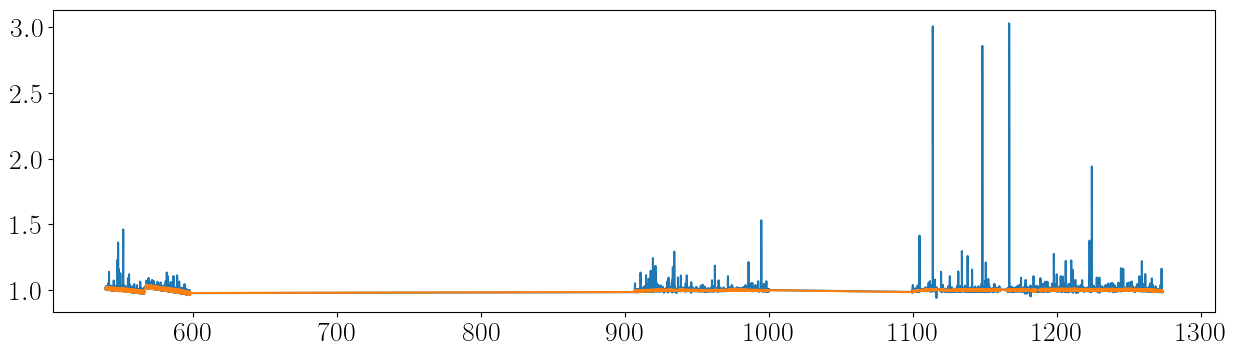

In [15]:
#Reading in the 11 mo gp files
from glob import glob

gp_files = glob('*11mo_*.csv')

for k in range(len(gp_files)): 
    df_tmp = pd.read_csv(gp_files[k]) 
    print(k, df_tmp.shape) 
    if k==0: 
        df = df_tmp 
    else: 
         df = df.append(df_tmp) 

df = df.sort_values(by='time')

plt.figure(figsize=(15,4))
plt.plot(df['time'], df['detrended_flux'])
plt.plot(df['time'], df['mean'])
plt.show()


In [16]:
#dropping the nans in the table
df = df.dropna()
df = df.reset_index(drop=True)
print(len(df))

453111


In [17]:
gj1243lc.time.bkjd

array([ 539.46009744,  539.46077857,  539.46145969, ..., 3904.40884054,
       3904.4102294 , 3904.41161827])

In [18]:
final_mask = np.zeros_like(gj1243lc.time.bkjd, dtype=bool)
for i in range(len(final_match['t_start'].values)):
    tf1 = (gj1243lc.time.bkjd >= final_match['t_start'].values[i]) & (gj1243lc.time.bkjd <= final_match['t_stop'].values[i])
    final_mask = final_mask + tf1 
print(final_mask)


no_flare_f = np.where((final_mask == False))[0]
flares_f = np.where((final_mask == True))[0]

[False False False ... False False False]


In [19]:
fj_mask = np.zeros_like(gj1243lc.time.bkjd, dtype=bool)
for i in range(len(flare_table['t_start'].values)):
    tj1 = (gj1243lc.time.bkjd >= flare_table['t_start'].values[i]) & (gj1243lc.time.bkjd <= flare_table['t_stop'].values[i])
    fj_mask = fj_mask + tj1 
print(fj_mask)


d14_no_flare = np.where((fj_mask == False))[0]
d14_flares = np.where((fj_mask == True))[0]
print(len(d14_flares))

[False False False ... False False False]
114571


Text(0.5, 0, 'Time - 2457000 [BTJD days]')

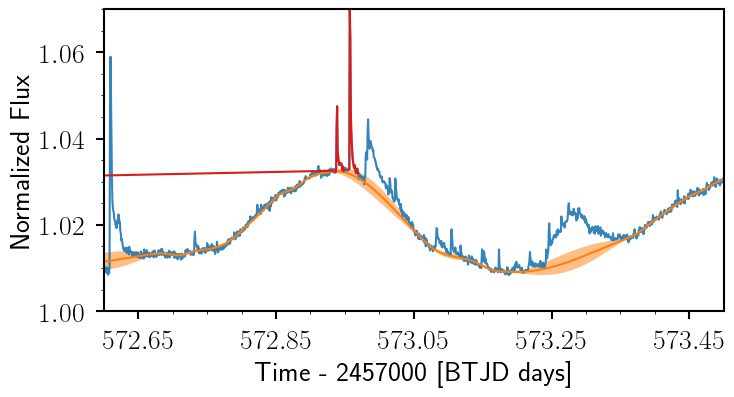

In [20]:

rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 4]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ['Verdana']#["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

#plt.figure(figsize=[8,4])

color = "#ff7f0e"

plt.rcParams['axes.linewidth']=1.5
#plt.rcParams['xtick.major.width'] = 1.5
#plt.rcParams['ytick.major.width'] = 1.5
#plt.rc('xtick.major', size=6, pad=5)


#plt.xticks(np.arange(572,574.5, step=0.5),fontname="sans-serif")


plt.plot(df['time'], df['detrended_flux'],alpha=0.9)
plt.plot(df['time'], df['mean'])
plt.fill_between(df['time'], df['mean']+df['std'], df['mean']-df['std'],color=color, alpha=0.5,
                 edgecolor="none",label='gp')
#plt.plot(df['time'][flares].values[2573:2609],df['detrended_flux'][flares].values[2573:2609],color='#D81B1B')
plt.plot(df['time'][flares_f].values[2615:2658],df['detrended_flux'][flares_f].values[2615:2658],color='#D81B1B')
plt.plot(df['time'][flares_f].values[2659:2681],df['detrended_flux'][flares_f].values[2659:2681],color='#D81B1B')
#plt.plot(df['time'][flares].values[2688:2700],df['detrended_flux'][flares].values[2688:2700],color='#D81B1B')

#plt.scatter(flare_table['t_peak'].values,flare_table['flux peak'].values+1,color='k',s=20)
#plt.scatter(cross_match['t_peak'].values,cross_match['flux peak'].values+1,color='k',s=20)
#plt.scatter(complex_flares['t_peak'].values,complex_flares['flux peak'].values+1,color='k',s=20)
plt.tick_params(direction='out',width=1.5,length=6,pad=7)
plt.minorticks_on()
plt.xticks(np.arange(572.65,573.5, step=0.2))
plt.xlim(572.6,573.5)
#plt.xlim(914,916)
plt.ylim(1,1.07)
plt.ylabel("Normalized Flux")
plt.xlabel("Time - 2457000 [BTJD days]")

#plt.savefig('/Users/lupitatovar/local_flares/figures/gp_overlay_wflares.png',bbox_inches='tight')

#plt.show()

Text(0.5, 0, 'Time - 2457000 [BTJD days]')

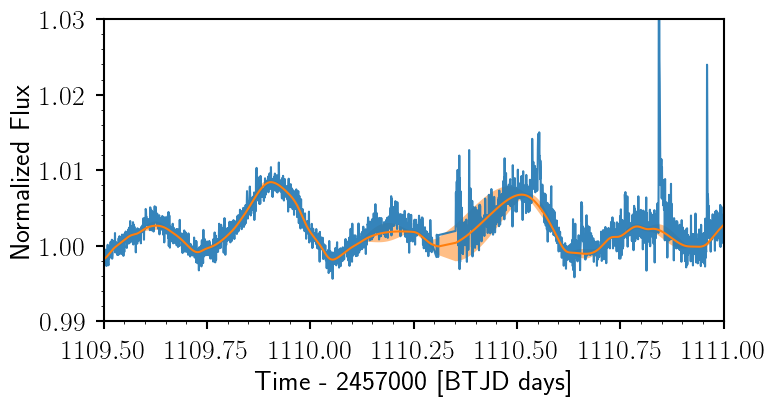

In [21]:

rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 4]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ['Verdana']#["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

#plt.figure(figsize=[8,4])

color = "#ff7f0e"

plt.rcParams['axes.linewidth']=1.5
#plt.rcParams['xtick.major.width'] = 1.5
#plt.rcParams['ytick.major.width'] = 1.5
#plt.rc('xtick.major', size=6, pad=5)


#plt.xticks(np.arange(572,574.5, step=0.5),fontname="sans-serif")


plt.plot(df['time'], df['detrended_flux'],alpha=0.9)
plt.plot(df['time'], df['mean'])
plt.fill_between(df['time'], df['mean']+df['std'], df['mean']-df['std'],color=color, alpha=0.5,
                 edgecolor="none",label='gp')
#plt.plot(df['time'][flares].values[2573:2609],df['detrended_flux'][flares].values[2573:2609],color='#D81B1B')
#plt.plot(df['time'][flares].values[2615:2658],df['detrended_flux'][flares].values[2615:2658],color='#D81B1B')
#plt.plot(df['time'][flares].values[2659:2681],df['detrended_flux'][flares].values[2659:2681],color='#D81B1B')
#plt.plot(df['time'][flares].values[2688:2700],df['detrended_flux'][flares].values[2688:2700],color='#D81B1B')

#plt.plot(df['time'][d14_flares].values,df['detrended_flux'][d14_flares].values,color='#D81B1B')


plt.tick_params(direction='out',width=1.5,length=6,pad=7)
plt.minorticks_on()
#plt.xticks(np.arange(572.65,573.5, step=0.2))
#plt.xlim(996,997.5) complex flare
#plt.xlim(993,993.8) #star spot varies
plt.xlim(1109.5,1111.)
plt.ylim(0.99,1.03)
plt.ylabel("Normalized Flux")
plt.xlabel("Time - 2457000 [BTJD days]")

#plt.savefig('/Users/lupitatovar/local_flares/figures/gp_overlay_wflares.png',bbox_inches='tight')

#plt.show()

In [22]:
detrended = df['detrended_flux'].values - df['mean'].values
print(detrended)

[ 0.00214614  0.00080994  0.00056504 ... -0.00054118 -0.00070254
 -0.0002242 ]


In [23]:
#timed_classical
classic_start=timed_classical.loc[:,'t_start'].values
classic_stop=timed_classical.loc[:,'t_stop'].values
classic_dur = timed_classical.loc[:,'Flare_Duration'].values
#classic_peak = timed_classical.loc[:,'Flux_peak'].values
#print(classic_start)

## Putting everything into a loop to stack all flares

Variables being calculated for the flare model: center time, scale height, scale duration

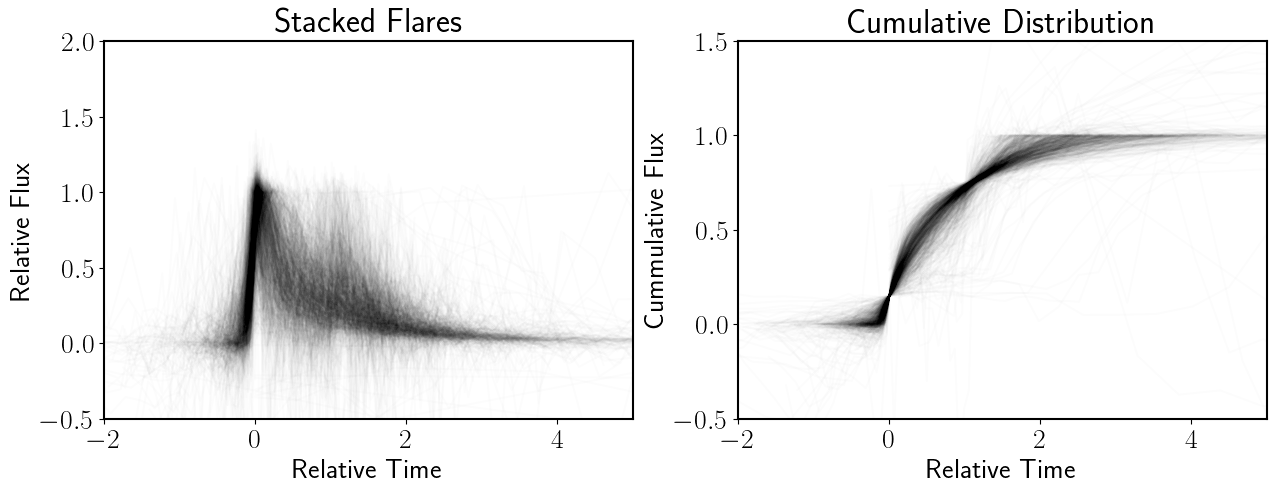

In [24]:
fig, axs = plt.subplots(1,2, figsize=(15, 5), facecolor='w', edgecolor='k')

t_center = np.array([])          # time at 50% cummulative flux of each flare
scale_height = np.array([])  # mean flux of the entire flare 
scale_dur = np.array([])     # (t_75 - t_25)


for i in range(0,len(timed_classical)):

    #Mask of the times (t_start and t_stop) between each flare 
    temp = np.where((df['time'] < timed_classical['t_stop'].values[i]) & 
                    (df['time'] > timed_classical['t_start'].values[i]))[0]
    
    # cummulative distribution of detrended fluxes within each flare
    cd_detrended = np.cumsum((detrended[temp])/np.sum(detrended[temp]))
    

    # interpolation over the flux of each flare: yvals are percentiles of cummulative flux & x_interp gives corresponding times
    # note that we are looking at times and fluxes in cummulative space
    
    yvals = np.array([0.15,0.25,0.75])
    xinterp = np.interp(yvals, cd_detrended, df['time'][temp])

    # t_50
    #cd_i_max = np.argmax(detrended[temp])
    #t_max = (df['time'].values[temp][cd_i_max])
    #cd_flux_max = (detrended[temp][cd_i_max])
    
    
    #double check this part
    t1 = xinterp[0]
    t2 = xinterp[1]#cd_flux_max / 2.0
    t3 = xinterp[2]
    
    t_center = np.append(t_center,t1)
    
    #i_xs = np.where((xinterp[temp] > t_50_flux[i]))[0]
    #time_xs = yvals[temp][i_xs]
    
    # defining the scale height
    cd_mean = np.cumsum(detrended[temp])    #explore this a little more (have tried mean, sum, median)
    #scale_height = np.append(scale_height,cd_mean)
    
    
    #testing interpolating over the fluxes instead of using mean flux
    height_interp = np.interp(0.99, np.linspace(0,1,len(detrended[temp])), np.sort(detrended[temp]))
    scale_height = np.append(scale_height,height_interp)
    
    # scale duration

    diff_dur = np.abs(t3 - t2)
    scale_dur = np.append(scale_dur,diff_dur)
    
    
    ######## PLOTTING ################

    cd_x = (df['time'][temp] - t_center[i])/(scale_dur[i])
    cd_y = ((detrended[temp])/(scale_height[i]))

    
    #ax1.plot(xinterp,yvals,'o',color='orange', label= 'interp data')

    axs[0].plot(cd_x,cd_y,color='k',alpha=0.01)

    #axs[1].plot((xinterp[2]-xinterp)/scale_dur[i],yvals,'x',color='orange',alpha=0.2)
    #axs[1].plot((df['time'][temp])/scale_dur[i],cd_detrended,color='k',alpha=0.2)
    axs[1].plot(cd_x,np.cumsum(cd_y)/np.sum(cd_y),color='k',alpha=0.01)
    #axs[1].scatter(df['time'][i]-xinterp[2],cd_detrended[i],color='k')#,alpha=0.5)
   

    #Setting Titles
    axs[0].set_title('Stacked Flares')
    axs[1].set_title('Cumulative Distribution')
    

    #Axes labels
    axs[0].set_xlabel("Relative Time")
    axs[0].set_ylabel("Relative Flux")    
    axs[1].set_ylabel("Cummulative Flux")
    axs[1].set_xlabel("Relative Time")

    #Axes limits
    axs[0].set_xlim(-2,5)
    axs[0].set_ylim(-0.5,2) 
    
    axs[1].set_xlim(-2,5)
    axs[1].set_ylim(-.5,1.5)
    #Legend
    #ax1.legend(loc='lower right')

    
    #plt.xlim(-2,5)
    #plt.ylim(-0.5,2)
    # cumulative distribution plot of the flares
    
    #plt.plot((xinterp - xinterp[1])/scale_dur[i],yvals,'x',color='orange')
    #plt.scatter(df['time'][i]- xinterp[2],cd_detrended[i])
    #plt.plot((df['time'][temp]- xinterp[1])/scale_dur[i],cd_detrended)
    #plt.xlabel("Time")
    #plt.ylabel("Flux")


## Stacked flares with final vetted flare list

### Final Flare Vetting

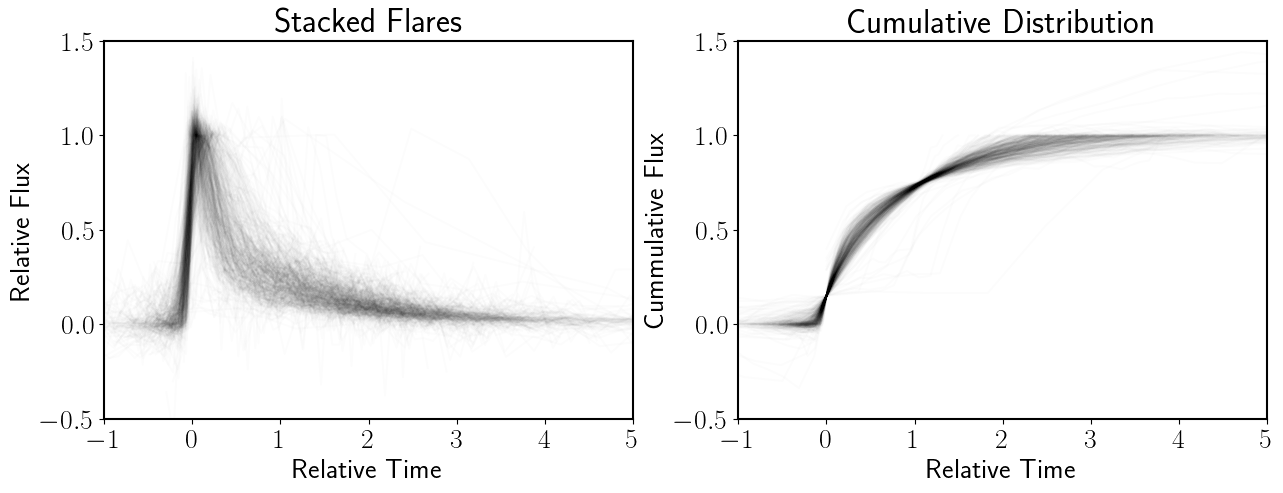

In [25]:
fig, axs = plt.subplots(1,2, figsize=(15, 5), facecolor='w', edgecolor='k')

t_center_final = np.array([])          # time at 50% cummulative flux of each flare
scale_height_final = np.array([])  # mean flux of the entire flare 
scale_dur_final = np.array([])     # (t_75 - t_25)

#arrays that get saved into .csv
x_all_final=np.array([])
y_all_final=np.array([])
y_err_final=np.array([])
gp_st_dev_final=np.array([])

for i in range(0,len(final_match)):

    #Mask of the times (t_start and t_stop) between each flare 
    tempf = np.where((df['time'] < final_match['t_stop'].values[i]) & 
                    (df['time'] > final_match['t_start'].values[i]))[0]
    
    # cummulative distribution of detrended fluxes within each flare
    cd_detrendedf = np.cumsum((detrended[tempf])/np.sum(detrended[tempf]))
    

    # interpolation over the flux of each flare: yvals are percentiles of cummulative flux & x_interp gives corresponding times
    # note that we are looking at times and fluxes in cummulative space
    
    yvals = np.array([0.15,0.25,0.75])
    f_xinterp = np.interp(yvals, cd_detrendedf, df['time'][tempf])

    # t_50
    #cd_i_max = np.argmax(detrended[temp])
    #t_max = (df['time'].values[temp][cd_i_max])
    #cd_flux_max = (detrended[temp][cd_i_max])
    
    
    #double check this part
    t1 = f_xinterp[0]
    t2 = f_xinterp[1]#cd_flux_max / 2.0
    t3 = f_xinterp[2]
    
    t_center_final = np.append(t_center_final,t1)
    
    #i_xs = np.where((xinterp[temp] > t_50_flux[i]))[0]
    #time_xs = yvals[temp][i_xs]
    
    # defining the scale height
    cd_meanf = np.cumsum(detrended[tempf])    #explore this a little more (have tried mean, sum, median)
    #scale_height = np.append(scale_height,cd_mean)
    
    
    #testing interpolating over the fluxes instead of using mean flux
    height_interp = np.interp(0.99, np.linspace(0,1,len(detrended[tempf])), np.sort(detrended[tempf]))
    scale_height_final = np.append(scale_height_final,height_interp)
    
    # scale duration

    diff_dur = np.abs(t3 - t2)
    scale_dur_final = np.append(scale_dur_final,diff_dur)
    
    
    ######## PLOTTING ################

    f_x2 = (df['time'][tempf] - t_center_final[i])/(scale_dur_final[i])
    f_y2 = ((detrended[tempf])/(scale_height_final[i]))
    
    
    
    #ax1.plot(xinterp,yvals,'o',color='orange', label= 'interp data')

    axs[0].plot(f_x2,f_y2,color='k',alpha=0.01)


    #axs[1].plot((xinterp[2]-xinterp)/new_scale_dur[i],yvals,'x',color='orange',alpha=0.2)
    axs[1].plot(f_x2,np.cumsum(f_y2)/np.sum(f_y2),color='k',alpha=0.01)
    
    #axs[1].scatter(df['time'][i]-xinterp[2],cd_detrended[i],color='k')#,alpha=0.5)
   

    #Setting Titles
    axs[0].set_title('Stacked Flares')
    axs[1].set_title('Cumulative Distribution')
    

    #Axes labels
    axs[0].set_xlabel("Relative Time")
    axs[0].set_ylabel("Relative Flux")    
    axs[1].set_ylabel("Cummulative Flux")
    axs[1].set_xlabel("Relative Time")

    #Axes limits
    axs[0].set_xlim(-1,5)
    axs[0].set_ylim(-0.5,1.5) 
    
    axs[1].set_xlim(-1,5)
    axs[1].set_ylim(-.5,1.5)
    #Legend
    #ax1.legend(loc='lower right')

    ########### Saving Arrays ########################
    
    # time array
    x_all_final = np.append(x_all_final,f_x2)
        
    #Flux Array
    y_all_final = np.append(y_all_final,f_y2)
        
       
        
        #    
    #i_max = np.argmax(detrended[temp])
    #flux_max = (detrended[temp][i_max])
    #new_peaks = np.append(new_peaks,flux_max)
        
    #Flux Errors
    
    flux_err_f = df['df_flux_err'][tempf].values/scale_height_final[i] #should this be divided by peak flux not scale height?
    y_err_final = np.append(y_err_final,flux_err_f)
        
    #GP Standard Deviation
    
    st_devf = df['std'][tempf].values/scale_height_final[i]
    gp_st_dev_final = np.append(gp_st_dev_final,st_devf)   
    #plt.savefig('stack_cd.png',bbox_inches='tight')

### Overplotting Jim's flare model onto this w/ amp=1,t_half=1,peak=0
https://github.com/jradavenport/appaloosa/blob/master/appaloosa/aflare.py

In [26]:
from scipy.stats import binned_statistic

def aflare1(t, tpeak, fwhm, ampl, upsample=False, uptime=10):
    '''
    The Analytic Flare Model evaluated for a single-peak (classical).
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723
    Use this function for fitting classical flares with most curve_fit
    tools.
    Note: this model assumes the flux before the flare is zero centered
    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    tpeak : float
        The time of the flare peak
    fwhm : float
        The "Full Width at Half Maximum", timescale of the flare
    ampl : float
        The amplitude of the flare
    upsample : bool
        If True up-sample the model flare to ensure more precise energies.
    uptime : float
        How many times to up-sample the data (Default is 10)
    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time
    '''
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]

    if upsample:
        dt = np.nanmedian(np.diff(t))
        timeup = np.linspace(min(t)-dt, max(t)+dt, t.size * uptime)

        flareup = np.piecewise(timeup, [(timeup<= tpeak) * (timeup-tpeak)/fwhm > -1.,
                                        (timeup > tpeak)],
                                    [lambda x: (_fr[0]+                       # 0th order
                                                _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                                _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                                _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                                _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                     lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                                _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                    ) * np.abs(ampl) # amplitude

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t-dt/2.,[max(t)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',
                                 bins=downbins)

    else:
        flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                 (t > tpeak)],
                                [lambda x: (_fr[0]+                       # 0th order
                                            _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                            _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                            _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                            _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                 lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                            _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                ) * np.abs(ampl) # amplitude

    return flare

#### Loading in arrays from .csv so that we don't need to re-run the loop above

 The arrays below contain time, flux, flux_err, and standard deviation for each flare
 stack_arrays_vet2 is the file that contains the latest values of vetted flares (total of 302 flares that are classical and also includes 37 that need start/stop times to be edited)

In [ ]:
#dict_n = {'time':x_all_final,'flux': y_all_final, 'flux_err': y_err_final, 'gp_st_dev': gp_st_dev_final} 
#final_stacking_arrays = pd.DataFrame(data=dict_n) 
#final_stacking_arrays.to_csv(r'final_stacking_array_values.csv',header=True,index=True)

In [27]:
#load in the arrays (no need to re-run the for loop above)

new_stacking_arrays=pd.read_csv('new_stacking_array_values.csv')
final_stacking_arrays=pd.read_csv('final_stacking_array_values.csv')

(-1.0, 5.0)

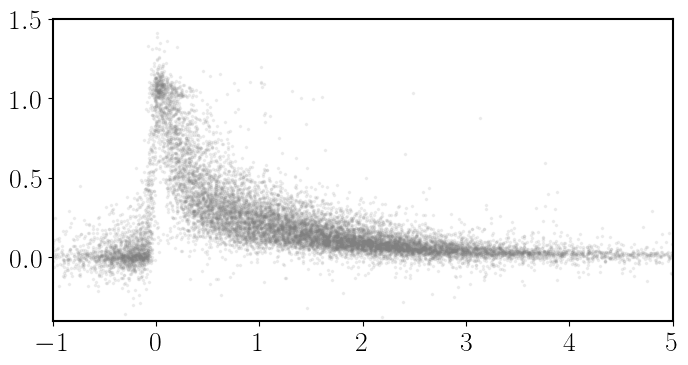

In [28]:
time = final_stacking_arrays['time'].values
flux = final_stacking_arrays['flux'].values
flux_err = final_stacking_arrays['flux_err'].values
gp_err = final_stacking_arrays['gp_st_dev'].values
both_errors = np.sqrt( (flux_err)**2 + (gp_err)**2 )

ns_all = np.argsort(time)
plt.scatter(time[ns_all],flux[ns_all],alpha=.1,s=10,marker='.',color='grey')
plt.ylim(-0.4,1.5)
plt.xlim(-1,5)

(-1.0, 5.0)

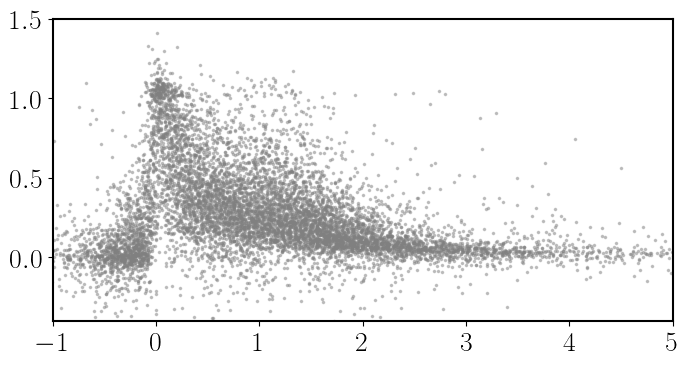

In [29]:
vet2_stack=pd.read_csv('stack_arrays_vet2.csv')
time_v2 = vet2_stack['time'].values
flux_v2 = vet2_stack['flux'].values
flux_err_v2 = vet2_stack['flux_err'].values
gp_err_v2 = vet2_stack['gp_st_dev'].values
both_errors_v2 = np.sqrt( (flux_err_v2)**2 + (gp_err_v2)**2 )

v2_sort = np.argsort(time_v2)
plt.scatter(time_v2[v2_sort],flux_v2[v2_sort],alpha=.4,s=10,marker='.',color='grey')
plt.ylim(-0.4,1.5)
plt.xlim(-1,5)

Text(0, 0.5, 'Relative Flux')

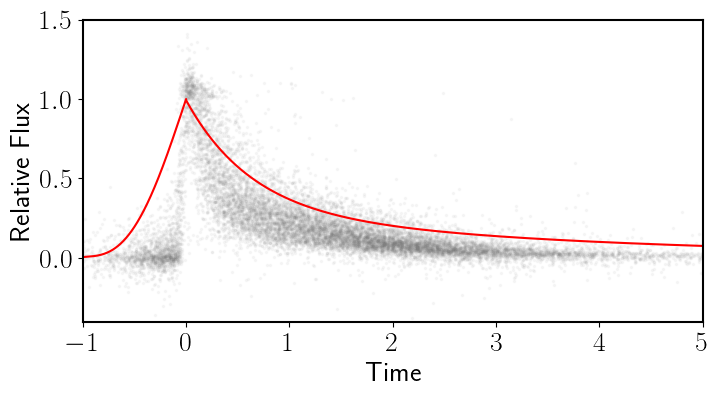

In [30]:

jim_model = aflare1(time,0,1,1)
plt.scatter(time[ns_all],flux[ns_all],alpha=.05,s=10,marker='.',color='grey')

plt.plot(time[ns_all],jim_model[ns_all],color='red')  

plt.ylim(-0.4,1.5)
plt.xlim(-1,5)
plt.xlabel('Time')
plt.ylabel('Relative Flux')

#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [33]:
#plot of the gp uncertainty in our detrended data
#plt.scatter(time[ns_all],gp_err[ns_all],alpha=.05,s=10,marker='.')
#plt.ylim(0,0.5)
#plt.xlim(-2,5)

Below is the flux error from the gp. We expect it to be a straight line centered at zero, however there is some variance between 0-0.3

In [ ]:
#plot the rolling mean and y_err

#plt.scatter(time[ns_all],flux_err[ns_all],alpha=.05,s=8,marker='.')
#plt.ylim(0,0.3)
#plt.xlim(-2,5)

In [ ]:
#plotting the variance of the st_dev (which is just the st_dev squared?)
#plt.scatter(time,gp_err**2,alpha=.05,s=10,marker='.')
#plt.ylim(-0.01,.1)
#plt.xlim(-2,5)

In [ ]:


#plt.scatter(time[ns_all],flux[ns_all],color='#00035b',alpha=0.2,s=12)
#axs[0].plot(new_x.rolling(2).median(),new_y,color='red')


#plt.plot(time[ns_all],example_median,color='#ca6641',lw=1.5)

#standard deviation of the median values
#plt.fill_between(time[ns_all], example_median+example_std, example_median-example_std,color='#ca6641', alpha=0.2,
                 #edgecolor="none")

#standard deviation of the median + the combined gp and photometric errors added in quadtrature
#plt.fill_between(time[ns_all], example_median+both_errors, example_median-both_errors,color='C0', alpha=0.2,
                 #edgecolor="none")




#plt.plot(new_x_all[new_sort],example_median+example_std,color='C0',alpha=0.5)
#plt.plot(new_x_all[new_sort],example_median-example_std,color='C0',alpha=0.5)
#plt.xlim(-1.1,5)
#plt.ylim(-0.5,1.5)

#plt.xlabel("Relative Time")
#plt.ylabel("Relative Flux") 

In [ ]:
#example_median=pd.Series(new_y_all[new_sort]).rolling(500, center=True).median()
#example_std = pd.Series(new_y_all[new_sort]).rolling(500, center=True).std()

#plt.scatter(time[ns_all],flux[ns_all],color='#00035b',alpha=0.2,s=12,label='stacked flares')
#axs[0].plot(new_x.rolling(2).median(),new_y,color='red')


#plt.plot(time[ns_all],example_median,color='#ca6641',lw=1.5,label='median')

#standard deviation of the median values
#plt.fill_between(time[ns_all], example_median+example_std, example_median-example_std,color='#ca6641', alpha=0.2,
                 #edgecolor="none",label='stand dev')

#standard deviation of the median + the combined gp and photometric errors added in quadtrature
#plt.fill_between(time[ns_all], example_median+both_errors, example_median-both_errors,color='C0', alpha=0.5,
                # edgecolor="none",label = 'chi2')

#plt.xlim(-1.1,5)
#plt.ylim(-0.5,1.5)

#plt.xlabel("Relative Time")
#plt.ylabel("Relative Flux") 
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

### Defining flare model

In [31]:
from scipy.stats import binned_statistic
def flare_model(t,tpeak, fwhm, ampl, upsample=False, uptime=10):

    '''
    The Continuous Flare Model evaluated for single-peak (classical) flare events.
    Use this function for fitting classical flares with most curve_fit
    tools.

    References
    --------------
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723
    Jackman et al. (2018)

    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over

    tpeak : float
        The time of the flare peak

    fwhm : float
        The Full Width at Half Maximum, timescale of the flare

    ampl : float
        The amplitude of the flare


    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time

        The convolution of a double exponential with a gaussian to give us a continuous flare model
    '''
    t_new = (t-tpeak)/fwhm +2
    #Note to user time needs to be sorted
    #consider adding a feat to sort t_new & needs to be unsorted at the end

    #Values were fit & calculated using MCMC 256 walkers and 10000 steps

    A,B,C,D1,D2,f1 = [2.93019203, 1.78279154, 0.3113989, 0.21181818, 1.63976688, 0.13602386]
    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    #if fwhm or ampl < 0:
    #return np.inf
    if upsample:
        dt = np.nanmedian(np.diff(np.abs(t_new)))
        timeup = np.linspace(min(t_new)-dt, max(t_new)+dt, t_new.size * uptime)

        flareup = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-timeup)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (timeup/C))))
                                                 + (f2 * np.exp((D2*(B-timeup)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (timeup/C)))))

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t_new-dt/2.,[max(t_new)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',bins=downbins)
    else:
    
        flare = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t_new)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t_new/C))))
                                                 + (f2 * np.exp((D2*(B-t_new)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t_new/C)))))
    
    erf_bound = 0.5*(special.erf((t_new-0.2)*100) + 1)
    
    return flare * ampl * erf_bound    

### Calculating $ \chi ^2$ 

In [32]:
print(both_errors)

[0.06735671 0.06879949 0.07023016 ... 0.1372603  0.13913251 0.14100222]


In [33]:
xmin = -1
xmax = 5
x_mask = np.where((time[ns_all] > xmin) & (time[ns_all] < xmax))[0]
print(x_mask)

[  193   194   195 ... 13515 13516 13517]


In [34]:
ymin = -0.5
ymax= 1.5

both_mask = np.where((time[ns_all] > xmin) & (time[ns_all] < xmax) & (flux[ns_all] > ymin) & (flux[ns_all] < ymax))[0]
print(len(both_mask))

13324


In [35]:
print(len(both_errors))
print(len(both_errors[x_mask]))

13932
13325


In [36]:
#print('Chi Squared:' + str(np.sum(both_errors)))
#print('Chi Squared between time lim [-1,5]:'+str(np.sum(both_errors[x_mask])))

In [37]:
#chi2 = np.sum(((flux[ns_all][x_mask]- example_median[x_mask])/both_errors[ns_all][x_mask])**2)/(len(x_mask))
#print('Chi Squared between time lim [-1,5]:' +str(chi2))                                                                                        

In [38]:
#chi2_both = np.sum(((flux[ns_all][both_mask]- example_median[both_mask])/both_errors[ns_all][both_mask])**2)/(len(both_mask))
#print('Chi Squared with both_mask:' +str(chi2_both))   

Compute chi2 of the data vs the new flare model below:

In [39]:
from scipy import special
print(np.nansum(((flux[ns_all][both_mask]- flare_model(time[ns_all],0,1,1.2)[both_mask])/both_errors[ns_all][both_mask])**2)/(len(both_mask)))

298.4617485899284


In [40]:
both_mask_v2 = np.where((time_v2[v2_sort] > xmin) & (time_v2[v2_sort] < xmax) & (flux_v2[v2_sort] > ymin) & (flux_v2[v2_sort] < ymax))[0]
print(len(both_mask_v2))


print(np.nansum(((flux_v2[v2_sort][both_mask_v2]- flare_model(time_v2[v2_sort],0,1,1.2)[both_mask_v2])/both_errors_v2[v2_sort][both_mask_v2])**2)/(len(both_mask_v2)))


9085
112.00244529818457


### Fitting New Flare Model to GJ1243 data

Text(0, 0.5, 'Relative Flux')

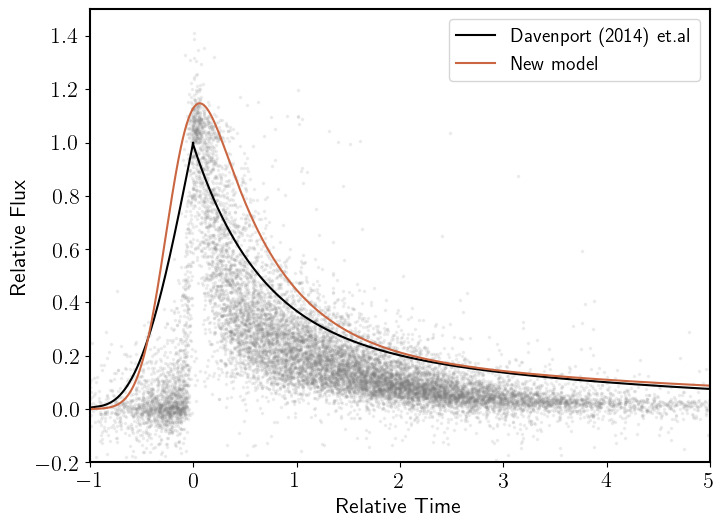

In [41]:
plt.figure(figsize=(8, 6))
font = {'size'   : 16}
plt.rc('font', **font)

plt.plot(time[ns_all],jim_model[ns_all],color='black',label='Davenport (2014) et.al')
#plt.plot(time[ns_all]-2,flare_model(time,0,1,1)[ns_all],label='New model',color='C0')
plt.plot(time[ns_all],flare_model(time,0,1,1.2)[ns_all],label='New model',color='#ca6641')
#plt.plot(time[ns_all],jackman2(time,(0.91780987, 1.72326426, 0.25978216, 0.81791936, 72.63673096, 2.76862114))[ns_all],label='Jims vals',color='orange')
plt.scatter(time[ns_all],flux[ns_all],alpha=0.1,s=10,marker='.',color='grey')
#plt.xlim(-4,5)
plt.ylim(-0.2,1.5)
plt.xlim(-1,5)
plt.legend(loc='upper right',fontsize=14)
plt.xlabel('Relative Time')
plt.ylabel('Relative Flux')

In [42]:
old_stack=pd.read_csv('stacked_flare_values.csv')
#old_stack
old_time = old_stack['time'].values
os_sort = np.argsort(old_time)
model2014 = aflare1(old_time,0,1,1)
model2020 = flare_model(old_time,0,1,1.05)

Text(0.5, 1.0, 'V2')

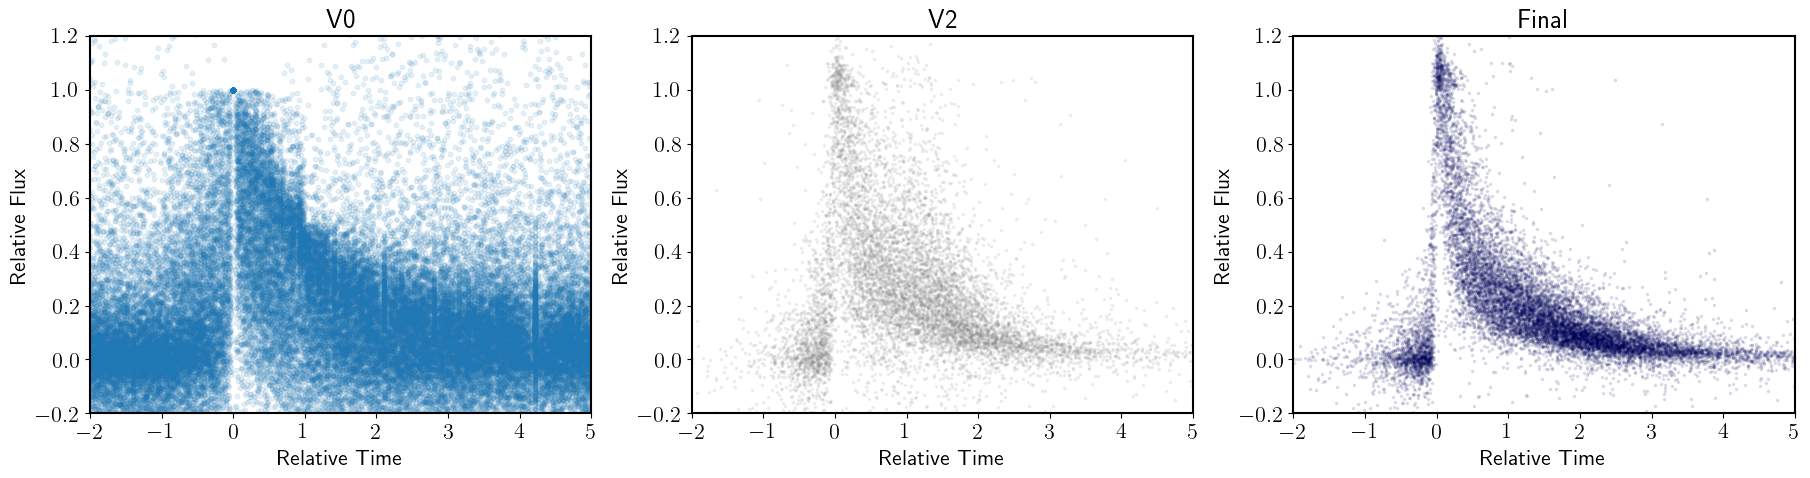

In [43]:
fig, axs = plt.subplots(1,3, figsize=(22, 5), facecolor='w', edgecolor='k')
axs[2].scatter(time[ns_all],flux[ns_all],alpha=.1,s=10,marker='.',color='#00035b',label='Final')
axs[0].scatter(old_time[os_sort],old_stack['flux'][os_sort],color='C0',alpha=0.1,s=10,label='V0')
axs[1].scatter(time_v2[v2_sort],flux_v2[v2_sort],alpha=.1,s=10,marker='.',color='grey',label='V2')
#plt.plot(time[ns_all],aflare1(time,0,1,1)[ns_all],color='black',label='Davenport (2014) et al.')
#plt.plot(time[ns_all]-2,flare_model(time,0,1,1)[ns_all],label='New model',color='C0')
#plt.plot(time[ns_all],flare_model(time,-2,1,1.2)[ns_all],label='New model',color='#ca6641')
axs[0].set_ylim(-0.2,1.2)
axs[0].set_xlim(-2,5)

axs[1].set_ylim(-0.2,1.2)
axs[1].set_xlim(-2,5)

axs[2].set_ylim(-0.2,1.2)
axs[2].set_xlim(-2,5)

axs[0].set_xlabel('Relative Time')
axs[0].set_ylabel('Relative Flux')

axs[1].set_xlabel('Relative Time')
axs[1].set_ylabel('Relative Flux')

axs[2].set_xlabel('Relative Time')
axs[2].set_ylabel('Relative Flux')

axs[2].set_title('Final')
axs[0].set_title('V0')
axs[1].set_title('V2')
#plt.legend(loc='upper right',fontsize=16)
#plt.savefig('flare_sample_comparison.png',bbox_inches='tight')

In [44]:
print(len(old_time))
print(len(time))
print(len(time_v2))

157194
13932
9649


Text(0, 0.5, 'Relative Flux')

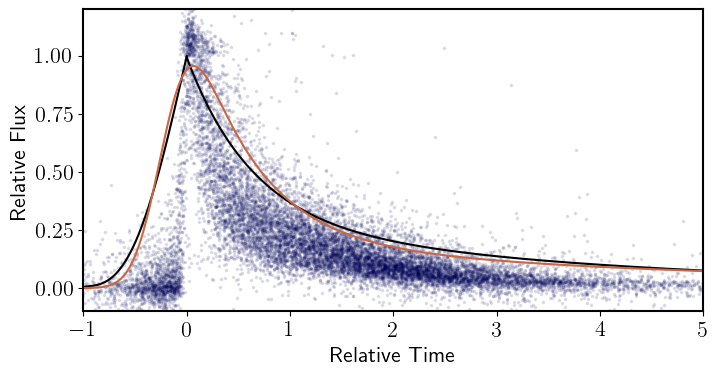

In [45]:
plt.scatter(time[ns_all],flux[ns_all],alpha=.1,s=10,marker='.',color='#00035b')
#plt.scatter(old_time[os_sort],old_stack['flux'][os_sort],color='C0',alpha=0.01,s=12)
plt.plot(time[ns_all],aflare1(time,0,1,1)[ns_all],color='black',label='Davenport (2014) et al.')
#plt.plot(time[ns_all]-2,flare_model(time,0,1,1)[ns_all],label='New model',color='C0')
plt.plot(time[ns_all],flare_model(time,0,1,1)[ns_all],label='New model',color='#ca6641')
plt.ylim(-0.1,1.2)
plt.xlim(-1,5)
plt.xlabel('Relative Time')
plt.ylabel('Relative Flux')
#plt.legend(loc='upper right',fontsize=16)
#plt.savefig('new_stack_both_models.png',bbox_inches='tight')

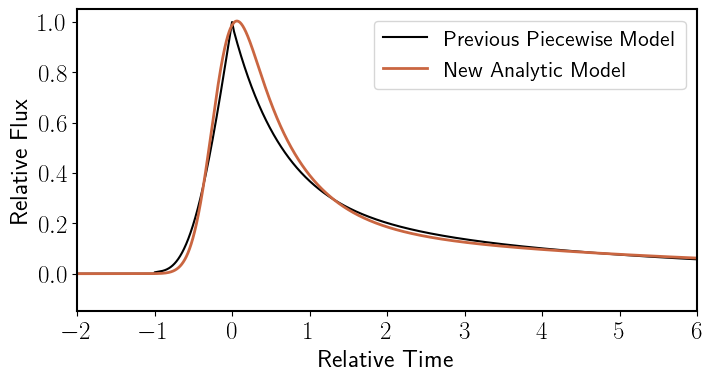

In [46]:
rcParams["font.size"] = 18
#rcParams["figure.figsize"] = [8, 4]
#rcParams["font.family"] = "sans-serif"
#rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
#rcParams["text.usetex"] = True

plt.figure(figsize=[8,4])

#color = "#ff7f0e"

plt.rcParams['axes.linewidth']=1.5


#plt.scatter(old_time[os_sort],old_stack['flux'][os_sort],color='C0',alpha=0.05,s=10)
plt.plot(old_time[os_sort],model2014[os_sort],color='black',label='Previous Piecewise Model',lw=1.5)
plt.plot(old_time[os_sort],model2020[os_sort],color='#ca6641',label='New Analytic Model',lw=2)
plt.xlim(-2,6)
plt.ylim(-0.15,1.05)
plt.xlabel('Relative Time')
plt.ylabel('Relative Flux')
#plt.savefig('/Users/lupitatovar/TESS_Cycle4/figures/flare_models.png',bbox_inches='tight')
plt.legend(loc = 'upper right',fontsize=16)#bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#plt.savefig('/Users/lupitatovar/TESS_Cycle4/figures/flare_models.png',bbox_inches='tight')

### Fitting each flare

In [47]:
from scipy.optimize import least_squares,curve_fit, minimize

### Fitting each flare within the cross-match table
The resulting fits for each flare (i.e the 'best_vals') will be used as input data to stack the flares using the old stacking procedure. From there the new stack of flares will be fit using mcmc, and the resulting chi^2 of stack will be our numerical comparison to evaluate which stacking procedure is more efficient

Re-running with final vetted flare list 

In [48]:
error1 = np.sqrt( (((df['df_flux_err'].values)**2)) + (((df['std'].values)**2)))

In [317]:
print(error1)

[0.0004154  0.00040568 0.0003976  ... 0.00038115 0.00038811 0.00039677]


In [49]:
#coeffs = []
tpeaks = [] 
fwhms = [] 
amps = []

tpeaks_err = []
fwhms_err = []
amps_err = []
#t, tpeak, fwhm, ampl
for i in range (0,len(final_match)):

    #taking care of nan_arrays

    t_nan_array = np.isnan(time[ns_all])
    t_not_nan_array = ~ t_nan_array
    no_nan_time = time[t_not_nan_array]

    no_infs = np.isfinite(no_nan_time)

    #Defining times of each flare event
    i_temp2 = np.where((df['time'].values <= final_match['t_stop'].values[i]+0.01) & 
                    (df['time'].values >= final_match['t_start'].values[i]-0.005))[0]
    
    peak_flujo = final_match['t_stop'].values-final_match['t_start'].values
    # arrays to feed into curvefit
    #x_to_fit = no_nan_time[no_infs]
    #y_to_fit = flux[t_not_nan_array][no_infs]
    
    x_fit = df['time'].values[i_temp2]
    y_fit = detrended[i_temp2]


    #defining the error array to feed into curvefit
    #error1 = np.sqrt( (((df['df_flux_err'].values)**2)) + (((df['std'].values)**2)))
    

    #print(error1)
    init_vals= [final_match['t_peak'].values[i],peak_flujo[i]/4,final_match['flux peak'].values[i]]

    best_vals, covar = curve_fit(flare_model,x_fit,y_fit, p0=init_vals, maxfev=10000, sigma = error1[i_temp2],
                                  bounds=[[min(x_fit),0,0],[max(x_fit),peak_flujo[i],3*max(y_fit)]])
    
    #absolute_sigma = True
    #print('best_vals: {}'.format(best_vals))
    
    err = np.sqrt(np.diag(covar))
    ############# Saving Output Arrays ################
    tpeaks = np.append(tpeaks,best_vals[0])
    fwhms = np.append(fwhms,best_vals[1])
    amps = np.append(amps,best_vals[2])
    
    tpeaks_err = np.append(tpeaks_err,err[0])
    fwhms_err = np.append(fwhms_err,err[1])
    amps_err = np.append(amps_err,err[2])


In [51]:
print(tpeaks_err)
print(fwhms_err)
print(amps_err)

[5.47257178e-05 6.77026382e-05 6.09725947e-05 9.24925099e-05
 1.03804853e-04 3.82566319e-05 3.22003674e-05 5.46729118e-04
 1.74769290e-04 7.05557156e-05 1.87398891e-05 7.07792112e-05
 5.33067783e-05 5.09788512e-05 1.52969621e-04 3.25565824e-04
 5.07972563e-05 3.77008995e-05 2.85847425e-05 4.68280335e-05
 2.17824136e-04 4.94385769e-05 4.68686100e-05 4.62474855e-05
 2.16808597e-04 4.86400111e-05 1.47523524e-04 7.47915380e-05
 6.16348353e-05 2.60455927e-04 7.39912398e-05 4.69970933e-05
 1.72926398e-04 8.93039605e-05 1.47506605e-05 1.08026299e-04
 2.11496268e-05 1.13905788e-04 3.96852877e-05 1.40086768e-04
 6.45526055e-05 8.75332626e-05 2.67249325e-05 1.60140385e-05
 4.61638949e-06 5.04654361e-05 4.77630451e-05 4.05256328e-05
 5.07193322e-05 1.38960095e-04 7.29675531e-05 7.80746339e-05
 5.68174583e-05 5.99380224e-05 4.05770413e-04 5.48463122e-05
 1.00539628e-04 5.12386518e-05 3.43649372e-05 1.66326747e-04
 7.25792778e-05 1.33148926e-04 2.91028569e-05 1.10520900e-04
 9.40044043e-05 3.352231

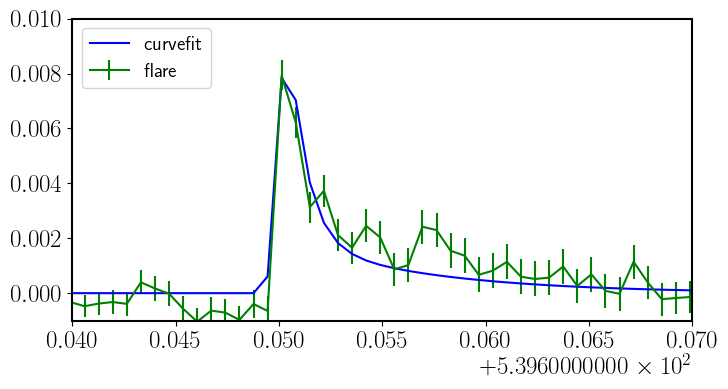

In [50]:
plt.plot(df['time'],flare_model(df['time'],tpeaks[0],fwhms[0],amps[0]),color='b',label='curvefit')
#plt.plot(df['time'],flare_model(df['time'],*init_vals),color='orange',label='init guess')
plt.errorbar(df['time'],detrended,color='green',label='flare',yerr=error1)
plt.xlim(539.64,539.67)
plt.ylim(-0.001,0.01)
plt.legend(loc='upper left',fontsize='14')

(545.0, 546.0)

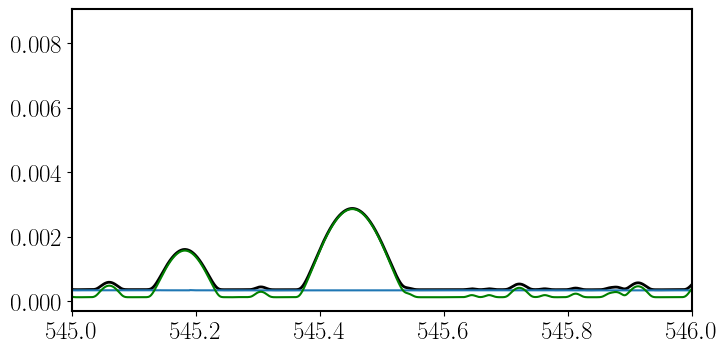

In [51]:
plt.plot(df['time'],error1,color='k',linewidth=2)
plt.plot(df['time'],df['df_flux_err'].values,color='C0') 
plt.plot(df['time'],df['std'].values,color='green')
plt.xlim(545,546)

(545.0, 546.0)

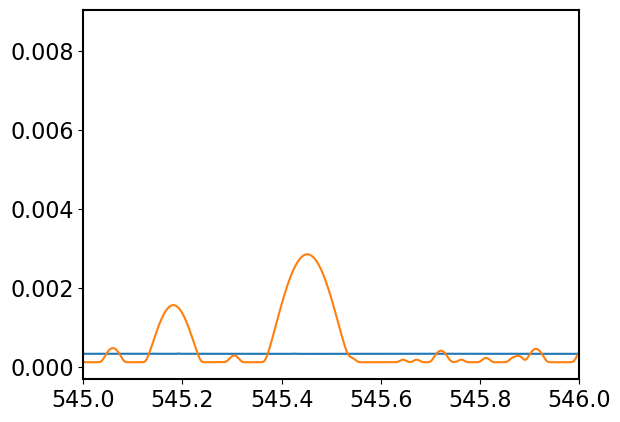

In [320]:
plt.plot(df['time'],df['df_flux_err'].values) 
plt.plot(df['time'],df['std'].values)
plt.xlim(545,546)

Stacking the flare fits using the old stacking procedure

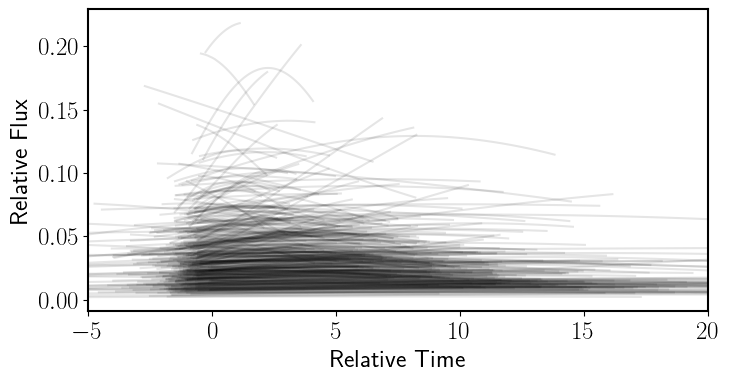

In [52]:
time_stack_fits=np.array([])
flux_stack_fits=np.array([])
stack_y_err = np.array([])
stack_gp_st_dev = np.array([])
xlim1=-5
xlim2=20
ylim1= -0.2
ylim2= 1.8

#plt.figure( figsize=(15, 5), facecolor='w', edgecolor='k')
for i in range(0,len(final_match)):
 
    
    #coeffs array already has these values: tpeak(time_max), fwhm(t_half), ampl(peak)
    # defining the variable to plot
    i_temp = np.where((df['time'].values <= final_match['t_stop'].values[i]) & 
                    (df['time'].values >= final_match['t_start'].values[i]))[0]
    
    temp_x_stack = (df['time'].values[i_temp] - tpeaks[i])/(fwhms[i])
    temp_y_stack = ((detrended[i_temp])/(amps[i]))
    #plt.plot(temp_x_stack,temp_y_stack,color='black',alpha=0.01)


    #Time Arrays
    nxs = np.where((temp_x_stack <= xlim2) & (temp_x_stack>=xlim1)& (temp_y_stack <= ylim2) & (temp_y_stack>=ylim1))[0]
    time_stack_fits = np.append(time_stack_fits,temp_x_stack[nxs])
        
    #Flux Arrays
    flux_stack_fits = np.append(flux_stack_fits,temp_y_stack[nxs])
        
    #Flux Errors
    new_flux_err = df['df_flux_err'].values[i_temp]/amps[i] 
    stack_y_err = np.append(stack_y_err,new_flux_err[nxs])
        
    #GP Standard Deviation
    new_st_dev = df['std'].values[i_temp]/amps[i]
    stack_gp_st_dev = np.append(stack_gp_st_dev,new_st_dev[nxs])
                  
   
    plt.plot(temp_x_stack,error1[i_temp]/amps[i],color='black',alpha=0.1)
    ########## PLOTTING ################
    #plt.plot(temp_x_stack,temp_y_stack,color='k',alpha=0.01)

    #the plot below is in cumulative distribution space
    #plt.plot(temp_x_stack,np.cumsum(temp_y_stack)/np.sum(temp_y_stack),color='k')

   

    #Setting Titles
    #axs[0].set_title('Stacked Flares')
    #axs[1].set_title('Cumulative Distribution')
    

    #Axes labels
    plt.xlabel("Relative Time")
    plt.ylabel("Relative Flux")    
    #axs[1].set_ylabel("Cummulative Flux")
    #axs[1].set_xlabel("Relative Time")

    #Axes limits
    plt.xlim(-5,20)
    #plt.ylim(-0.2,1.8)
    
    
#plt.plot(x_new,aflare1(x_new,0,1,1),color='red',label='Jims Model')        
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)    
    

#plt.savefig('')


In [311]:
print(len(stack_gp_st_dev))

13421


In [312]:
print(len(time_stack_fits))

13421


## This is the final stack of flares that uses the new stacking procedure
Flares are fit using curvefit and the fits are used as alignments to stack the flares 

In [308]:
#saving the arrays to a file
#dict_i = {'time':time_stack_fits,'flux':flux_stack_fits , 'flux_err':stack_y_err , 'gp_st_dev':stack_gp_st_dev } 
#stacked_fit_flares = pd.DataFrame(data=dict_i) 
#stacked_fit_flares.to_csv(r'final_stacked_fits.csv',header=True,index=True)

In [53]:
fit_flare_vals=pd.read_csv('final_stacked_fits.csv')

Text(0, 0.5, 'Relative Flux')

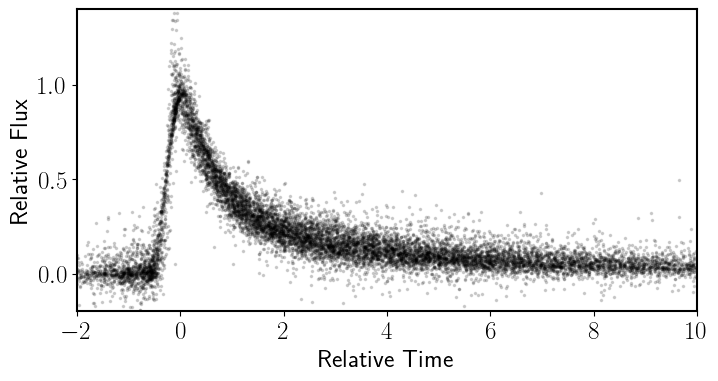

In [54]:
fit_time = fit_flare_vals['time'].values
fit_flux = fit_flare_vals['flux'].values
fit_flux_err = fit_flare_vals['flux_err'].values
fit_gp_err = fit_flare_vals['gp_st_dev'].values

fit_both_errors = np.sqrt( (fit_flux_err)**2 + (fit_gp_err)**2 )

fit_sort = np.argsort(fit_time)
plt.scatter(fit_time[fit_sort],fit_flux[fit_sort],alpha=.15,s=10,marker='.',color='k')
plt.ylim(-0.2,1.4)
plt.xlim(-2,10)
plt.xlabel("Relative Time")
plt.ylabel("Relative Flux")
#plt.savefig('/Users/lupitatovar/flares/figures/kepler_stacked_flares_final.png',bbox_inches='tight')

Text(0, 0.5, 'Relative Flux')

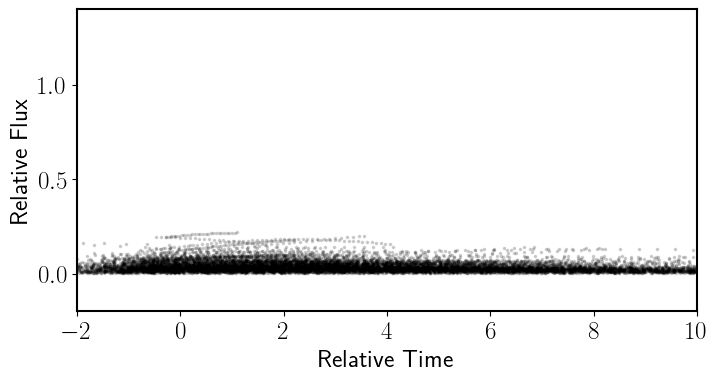

In [55]:
plt.scatter(fit_time[fit_sort],fit_both_errors[fit_sort],alpha=.15,s=10,marker='.',color='k')
plt.ylim(-0.2,1.4)
plt.xlim(-2,10)
plt.xlabel("Relative Time")
plt.ylabel("Relative Flux")

Text(0, 0.5, 'Relative Flux')

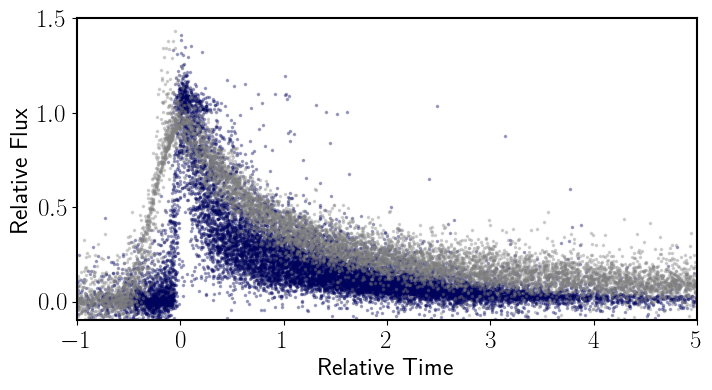

In [56]:
plt.scatter(time[ns_all],flux[ns_all],alpha=.3,s=10,marker='.',color='#00035b')
plt.scatter(fit_time[fit_sort],fit_flux[fit_sort],alpha=.3,s=10,marker='.',color='grey')
#plt.scatter(old_time[os_sort],old_stack['flux'][os_sort],color='C0',alpha=0.01,s=12)
#plt.plot(time[ns_all],aflare1(time,0,1,1)[ns_all],color='black',label='Davenport (2014) et al.')
#plt.plot(time[ns_all]-2,flare_model(time,0,1,1)[ns_all],label='New model',color='C0')
#plt.plot(time[ns_all],flare_model(time,0,1,1)[ns_all],label='New model',color='#ca6641')
plt.ylim(-0.1,1.5)
plt.xlim(-1,5)
plt.xlabel('Relative Time')
plt.ylabel('Relative Flux')
#plt.legend(loc='upper right',fontsize=16)
#plt.savefig('new_stack_both_models.png',bbox_inches='tight')

### Stacked Flare Diagnostics

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


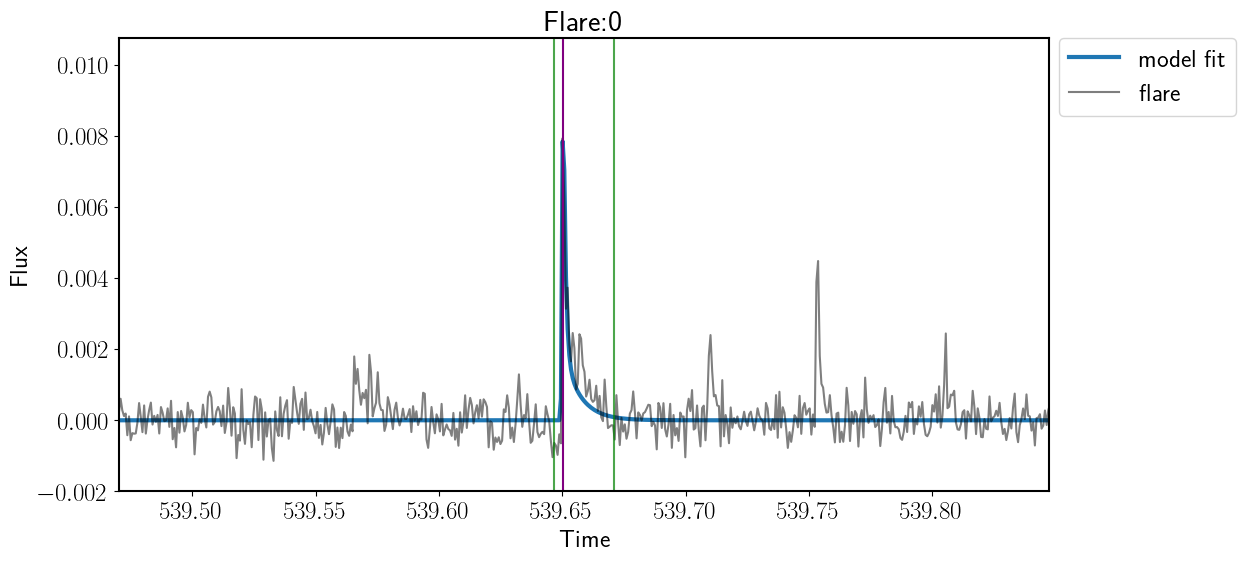

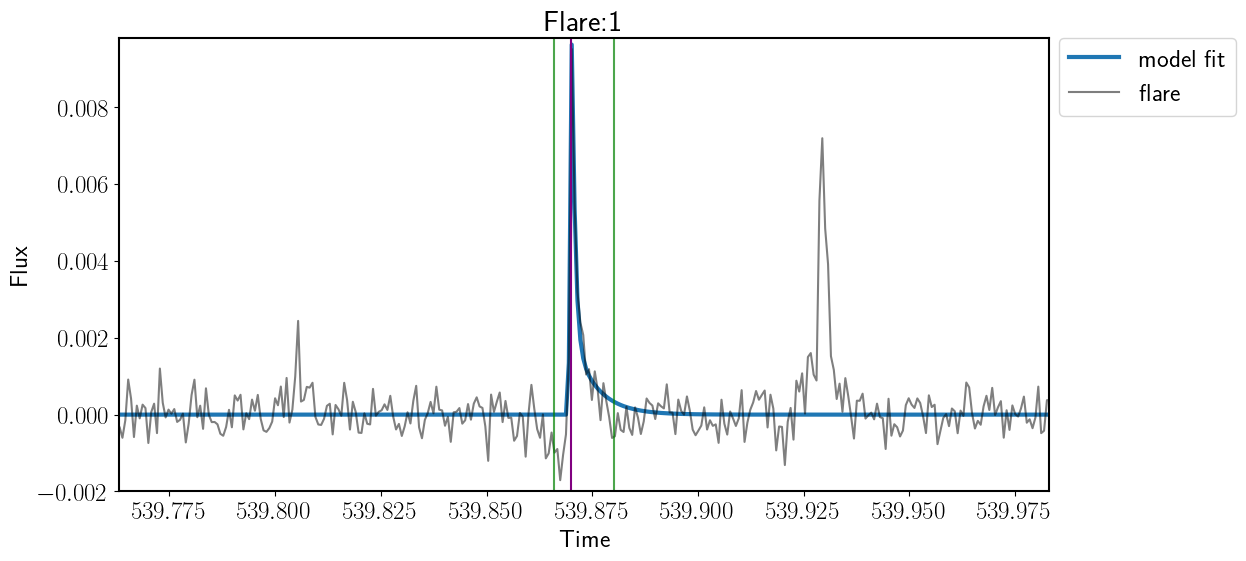

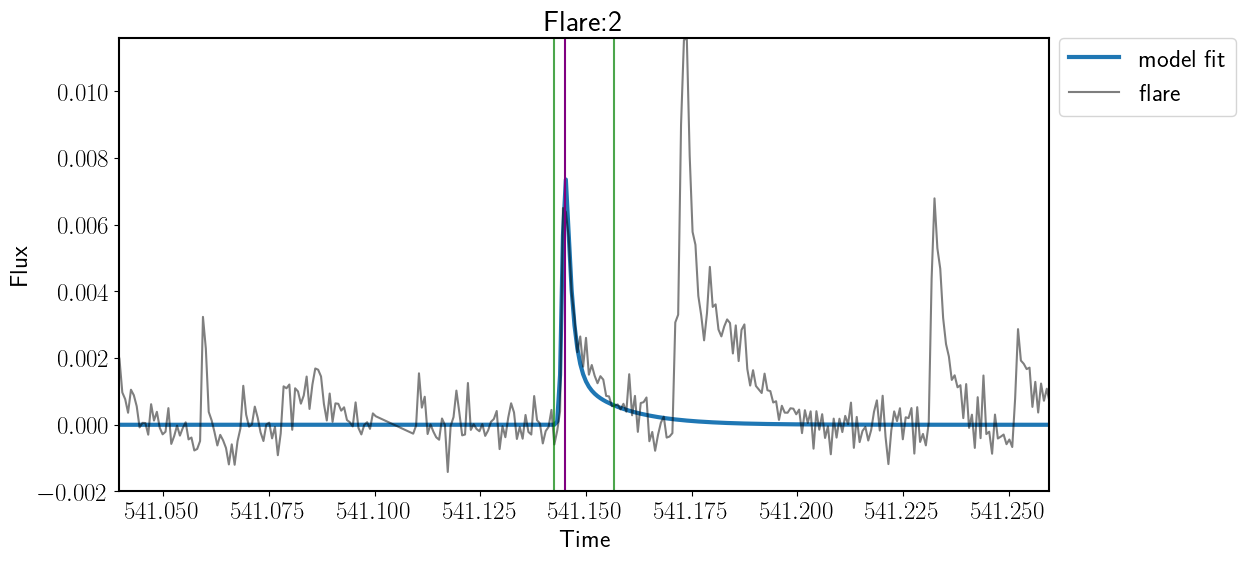

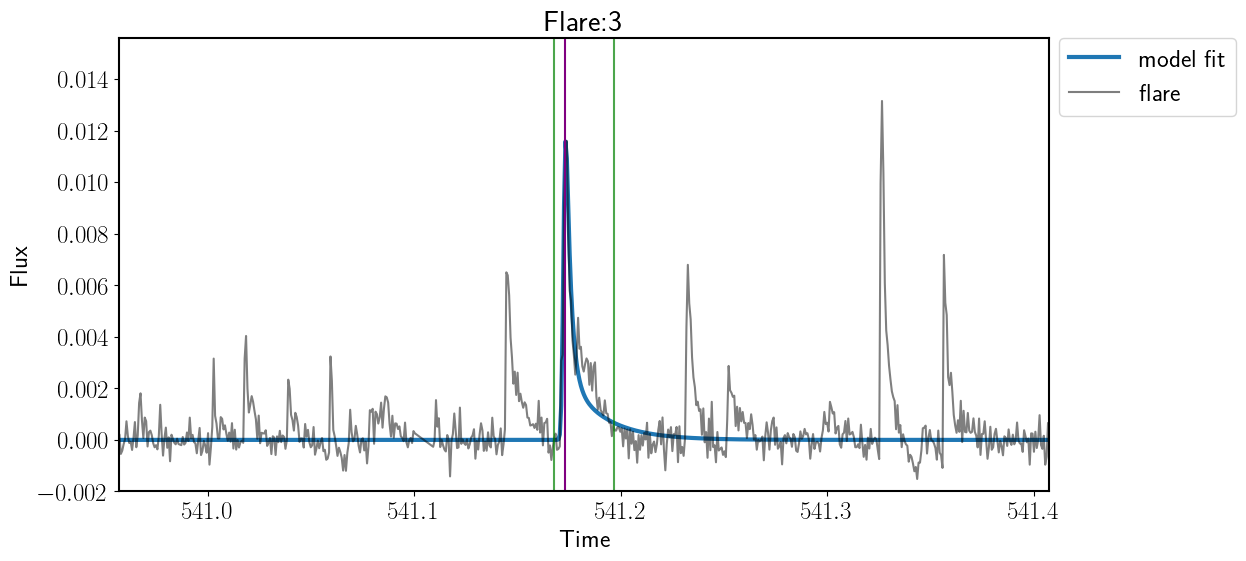

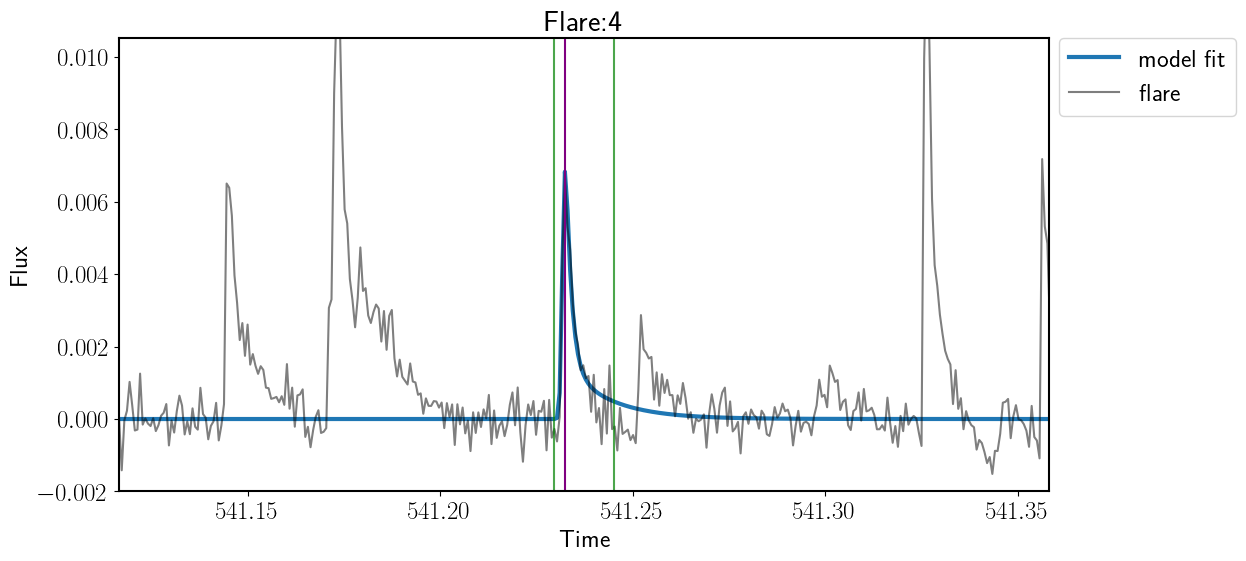

In [57]:
for i in range(0,5):#len(cross_match)):
    plt.figure(figsize=[12,6])
    #flux_fwhm = np.where(yinterp > half_peaks[i])[0] 
    
    #plt.scatter(tpeaks[i],amps[i],color='red',label='peak',s=50)
    i_temp = np.where((df['time'].values <= final_match['t_stop'].values[i]+0.01) & 
                    (df['time'].values >= final_match['t_start'].values[i]-0.005))[0]
    
    temp_x_stack = (df['time'].values[i_temp] - tpeaks[i])/(fwhms[i])
    temp_y_stack = ((detrended[i_temp])/(amps[i]))
    #plt.plot(temp_x_stack[i],temp_y_stack[i],color='black')
    #plt.plot(xvals,yinterp,color='black',alpha=0.8,label='interp_data')
    #plt.plot(np.where(xvals,np.where((yinterp > half_peaks[i]))[0],color='black',alpha=0.8,label='interp_data')
    #plt.scatter(xvals[flux_fwhm],yinterp[flux_fwhm], color='red', s=20,label='flux>fwhm',alpha=0.5)

    plt.plot(df['time'],flare_model(df['time'],tpeaks[i],fwhms[i],amps[i]),color='C0',label='model fit',lw=3)

    plt.plot(df['time'],detrended,color='black',label='flare',alpha=0.5)

    #plt.axhline(y=half_peaks[i], color='green', linestyle='-',label='t_half',alpha=0.7)
    plt.axvline(x=final_match['t_start'].values[i], color='green', linestyle='-',alpha=0.7)
    plt.axvline(x=final_match['t_stop'].values[i], color='green', linestyle='-',alpha=0.7)
    plt.axvline(x=tpeaks[i], color='purple', linestyle='-')
    

    plt.ylim(-.002,final_match['flux peak'].values[i]+.005)
    #plt.xlim(timed_classical['t_start'].values[i]-.1,timed_classical['t_stop'].values[i]+.1)
    plt.xlim(final_match['t_start'].values[i]-.005*final_match['Flare_Duration'].values[i],final_match['t_stop'].values[i]+.005*final_match['Flare_Duration'].values[i])
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    plt.title('Flare:'+ str(i))
    plt.xlabel('Time')
    plt.ylabel('Flux')
    #plt.savefig('/Users/lupitatovar/local_flares/notebooks/flare_diagnostics2/'+'flare'+str(i)+'.png',bbox_inches='tight')
    #plt.close()

### Emcee Fit

In [58]:
import emcee
from IPython.display import display, Math
import corner

In [59]:
A_i,B_i,C_i,D1_i,D2_i,f1_i = [3.62811083, 1.75000175, 0.20359971, 1.35488483, 0.1790915,  0.8107078]
#[18.01135643,  1.97206759,  0.04491244,  6.53569798,  0.93887231,  0.61831039] values for cumulative dist stack
#[3.40885267,  3.74774459, -0.21710296,  0.16109176,  1.35048373,  0.18575378]
#2.93019203, 1.78279154, 0.3113989, 0.21181818, 1.63976688, 0.13602386 numbers from model V0 run
#3.40885267  3.74774459 -0.21710296  0.16109176  1.35048373  0.18575378

def jackman2(t_in,theta2):
    t= t_in +2
    A,B,C,D1,D2,f1=theta2
    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    double_exp = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t/C)))) 
                                             + (f2 * np.exp((D2*(B-t)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t/C)))))
    erf_bound = 0.5*(special.erf((t)*100) + 1)
    #erf_bound = 0.5*(special.erf((t-0.2)*100) + 1)
    return double_exp*erf_bound


def lnlike2(theta2, time, flux, both_errors):
    debug = True
    A,B,C,D1,D2,f1 = theta2
    jackman_model = jackman2(time,theta2)
    #erf_bound = 0.5*(special.erf((time-0.2)*100) + 1)
    #model = jackman_model*erf_bound
    # the dreaded negative-number cliff!
    #if (np.nanmin(model) >= 0) and ((jackman2(np.array([-1000.]),theta2)* (0.5*(special.erf((-1000-0.2)*100) + 1))) >= 0):
    if (np.nanmin(jackman_model) < 0):    
        if degug:
            print('DEBUG: model>0 error')
        return -np.inf
    
    #if (jackman2(np.array([-1000.]),theta2)* (0.5*(special.erf((-1000-0.2)*100) + 1))) < 0:
    if (jackman2(np.array([-1000.]),theta2)* (0.5*(special.erf((-1000)*100) + 1))) < 0:
        if degug:
            print('DEBUG: -1000 error')    
        return -np.inf
        
    lnlike2 = -0.5*(np.sum(((flux-jackman_model)/both_errors)**2))
        #return lnlike2
    return lnlike2

def lnprior2(theta2):
    A,B,C,D1,D2,f1 = theta2
    debug = False
    if (D1 > 0.) and (0. <= f1 <= 1): #D1<0 | f1>1 #switch to and
        if debug:
            print('DEBUG:boundary')
        return 0.0
    #if not np.sum(np.isfinite(theta2)):
        #return -np.inf
    return -np.inf


def lnprob2(theta2, time, flux, both_errors):
    lp2 = lnprior2(theta2)
    debug = False
    try:
        # put the model<0 check in lnlike2!
        ll2 = lnlike2(theta2, time, flux, both_errors)
        output = lp2 + ll2
        if np.any(np.isnan(output)):
            return -np.inf
        return output
    except:
        if debug:
            print ('Debug: ambiguous fail')
        return -np.inf

In [60]:
print((jackman2(-1000,(A_i,B_i,C_i,D1_i,D2_i,f1_i))* (0.5*(special.erf((-1000-0.2)*100) + 1))) >= 0)
print(np.nanmin(jackman2(fit_time[fit_sort],(A_i,B_i,C_i,D1_i,D2_i,f1_i))* (0.5*(special.erf((fit_time)*100) + 1))))

False
0.0


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


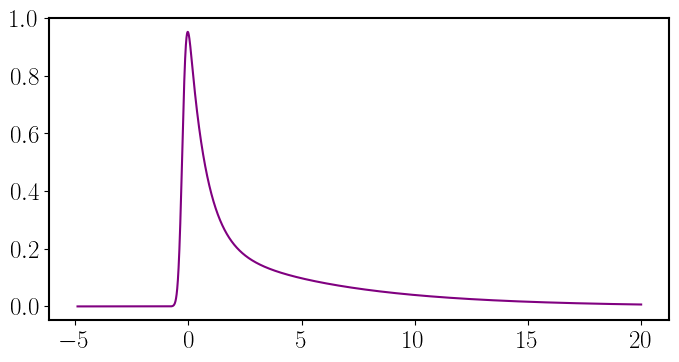

In [61]:
plt.plot(fit_time[fit_sort],jackman2(fit_time,(A_i,B_i,C_i,D1_i,D2_i,f1_i))[fit_sort],label='Jackman_guess',color='purple')

(-5.0, 10.0)

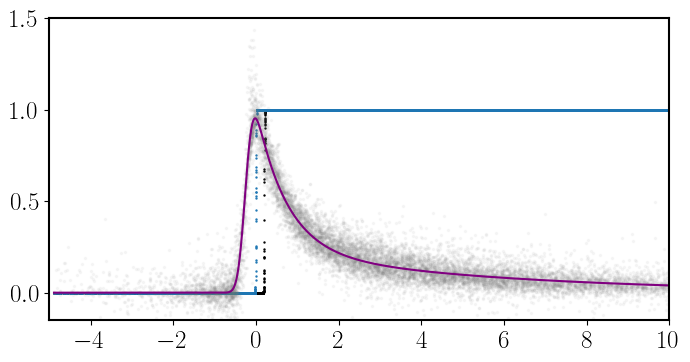

In [62]:
plt.scatter(fit_time, (0.5*(special.erf((fit_time-0.2)*100) + 1)),s=0.5,c='k')
plt.scatter(fit_time, (0.5*(special.erf((fit_time)*100) +1)),s=0.5)
plt.plot(fit_time[fit_sort],jackman2(fit_time,(A_i,B_i,C_i,D1_i,D2_i,f1_i))[fit_sort],label='Jackman_guess',color='purple')
#plt.plot(time[ns_all],jackman2(time,(A_i,B_i,C_i,D1_i,D2_i,f1_i))[ns_all],label='Jackman_guess',color='orange')
plt.scatter(fit_time[fit_sort],fit_flux[fit_sort],alpha=0.05,s=10,marker='.',color='grey')
plt.ylim(-0.15,1.5)
plt.xlim(-5,10)

In [63]:
initial2 = np.array([A_i,B_i,C_i,D1_i,D2_i,f1_i])
nwalkers2= 256 
ndim2=len(initial2)


pos2 = [np.array(initial2) + 1e-4 *np.random.rand(ndim2) for i in range(nwalkers2)]

In [64]:
#edit time and flux variables 
data = (fit_time[fit_sort],fit_flux[fit_sort],fit_both_errors[fit_sort])
#coords= np.random.randn(500, 6)
sampler2 = emcee.EnsembleSampler(nwalkers2, ndim2, lnprob2, args=data)#,backend=backend)


sampler2.run_mcmc(pos2, 30000, progress=True);

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]
100%|██████████| 30000/30000 [2:48:02<00:00,  2.98it/s]     


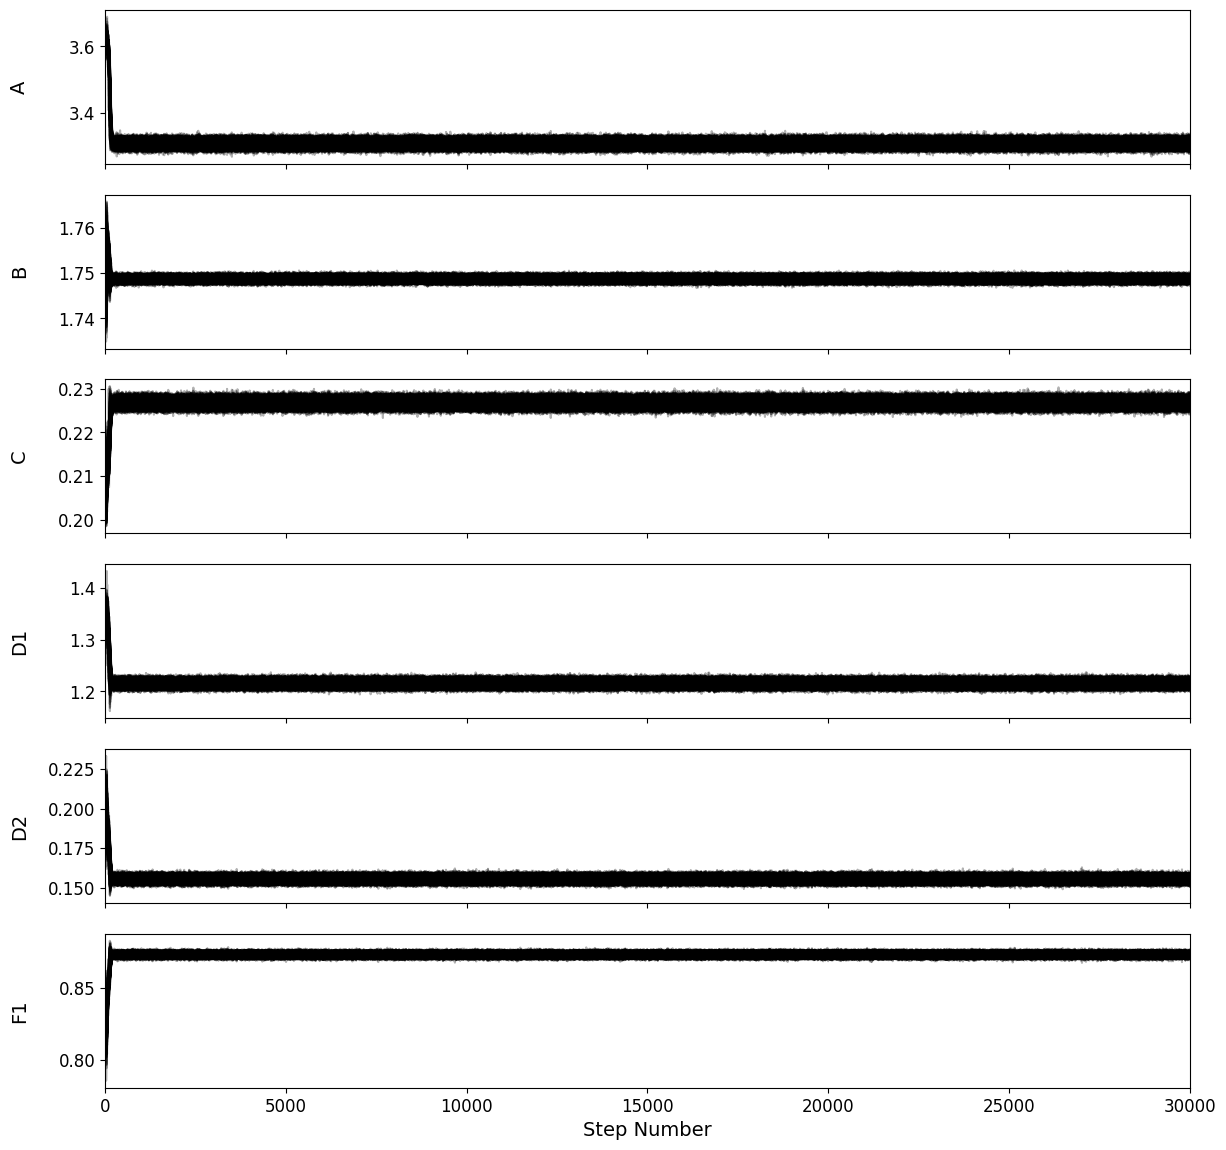

In [66]:
plt.style.use('default')
fig, axes = plt.subplots(6, figsize=(14, 14), sharex=True)
samples2 = sampler2.get_chain()
labels2 = ["A","B","C","D1","D2","F1"]
for i in range(ndim2):
    ax = axes[i]
    ax.plot(samples2[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples2))
    ax.set_ylabel(labels2[i],fontsize=14)
    ax.yaxis.set_label_coords(-.07,.5)
    ax.tick_params(axis='x',labelsize=12)
    ax.tick_params(axis='y',labelsize=12)


axes[-1].set_xlabel("Step Number",fontsize=14);
plt.savefig('/Users/lupitatovar/local_flares/figures/mcmc_plotted_vals_kep_final.png')

In [67]:
import matplotlib.ticker as mtick
from matplotlib.ticker import ScalarFormatter


(1382400, 6)


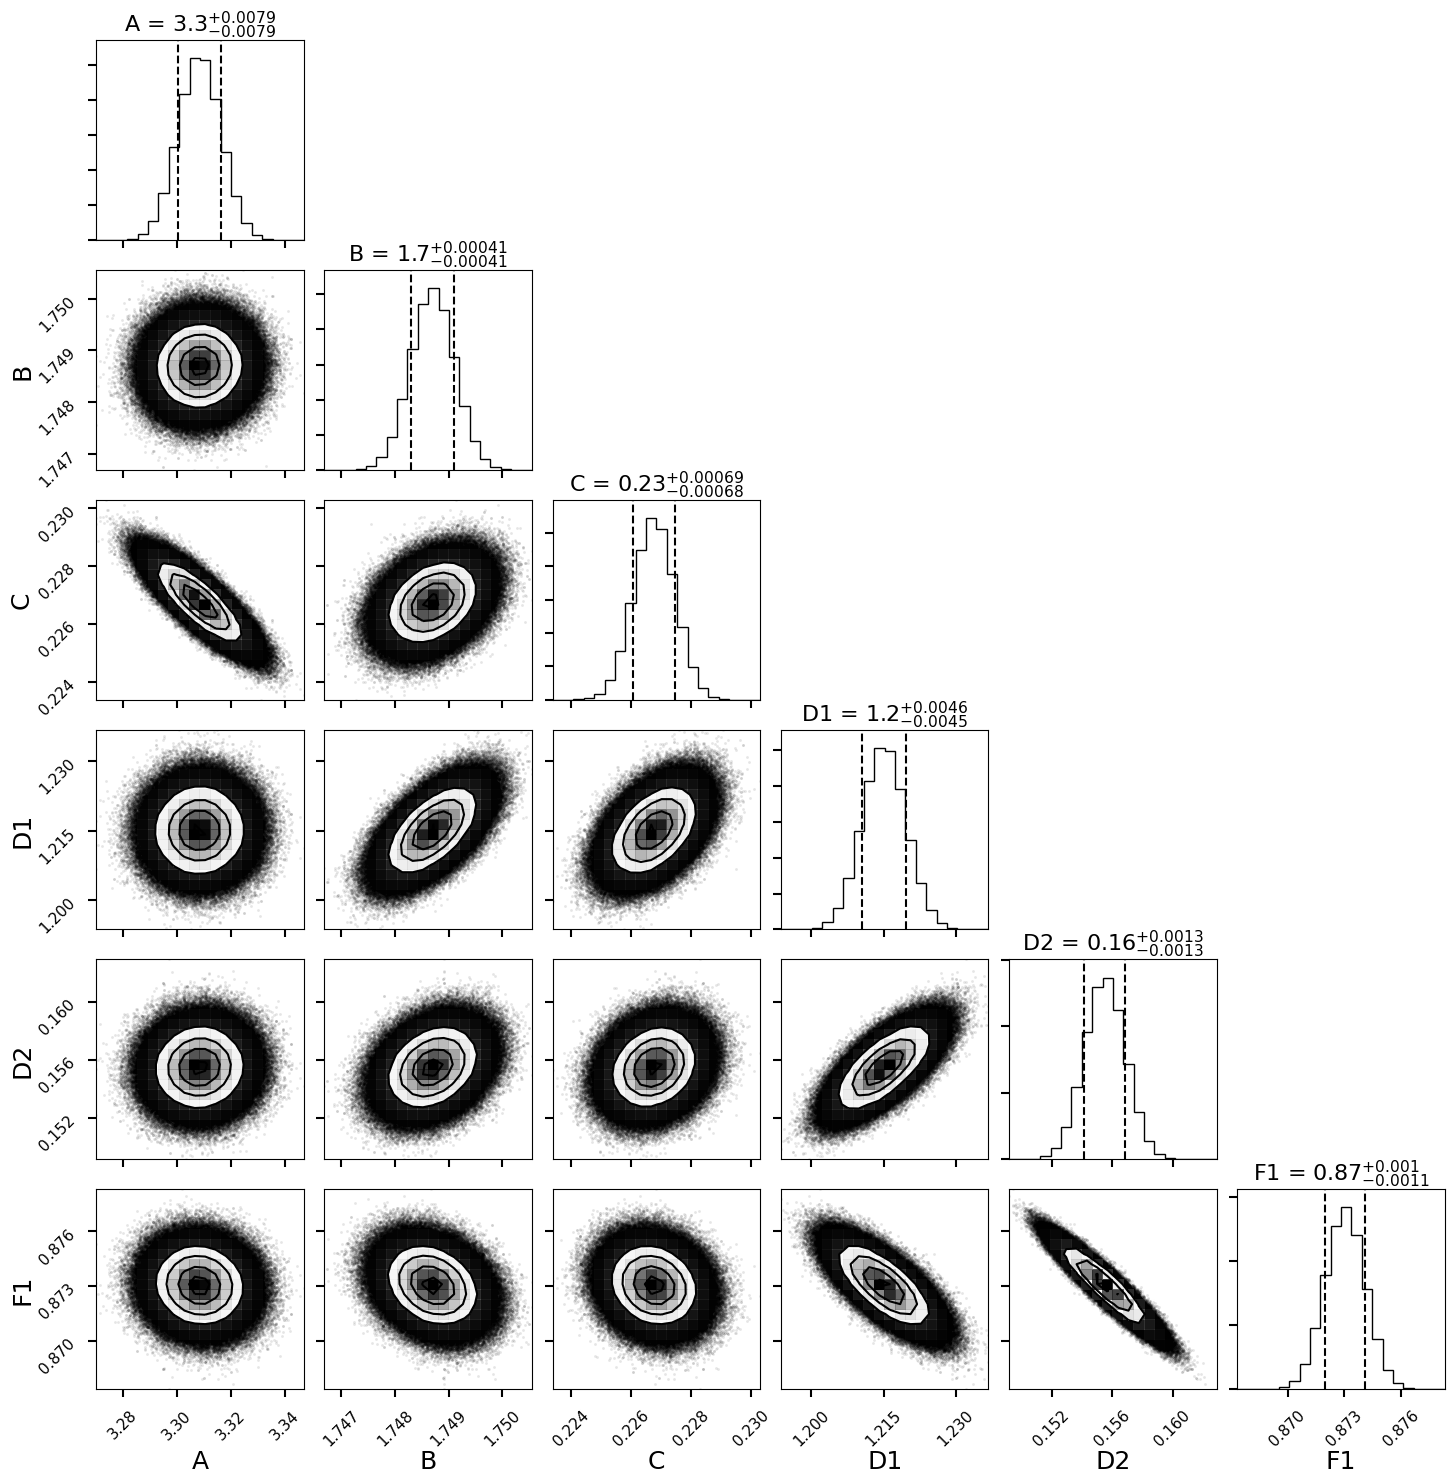

In [93]:

flat_samples2 = sampler2.get_chain(discard=3000, thin=5, flat=True)
#discard the first 10% for longer runs
print(flat_samples2.shape)

fig = corner.corner(
    flat_samples2, labels=labels2,label_kwargs={"fontsize":18},show_titles=True,quantiles=[0.16, 0.84], title_kwargs={"fontsize": 16},
    max_n_ticks=4,title_fmt=".2"
);
for ax in fig.get_axes():
    fig.subplots_adjust(left=.001,bottom=.0009,wspace=0.1, hspace=0.15)
    #fig.subplots_adjust(wspace=0.7, hspace=0.6)
    ax.tick_params(axis='both', labelsize=11)
    ax.tick_params(direction='out',width=1.5,length=6,pad=7)
    xfmt = ScalarFormatter()
    xfmt.set_powerlimits((-1,2))
    ax.xaxis.set_minor_formatter(xfmt)
    #ax.xaxis.set_minor_formatter(mtick.FormatStrFormatter('% .2e'))
    #ax.set_xticklabels()
    #ax.ticklabel_format(axis='x',title_fmt=".001E")
    #ax.ticklabel_format(useMathText=True)
    
    
#plt.savefig('/Users/lupitatovar/local_flares/figures/mcmc_corner_kep_final.png',bbox_inches='tight')

In [86]:
#saving the sampler!!!
print(flat_samples2)
#mcmc_sampler = np.savetxt('mcmc_sampler.csv',flat_samples2, delimiter=',')

[[3.30056267 1.74889102 0.22765138 1.21700633 0.15565027 0.87307458]
 [3.30061828 1.74836588 0.22635928 1.20574084 0.15396412 0.87340849]
 [3.30649256 1.74846601 0.2268805  1.21846616 0.15708506 0.87150964]
 ...
 [3.30587161 1.74816527 0.22692386 1.21226086 0.15374766 0.87413899]
 [3.30396515 1.74899229 0.22708729 1.21527656 0.15494472 0.87348279]
 [3.32002115 1.74851629 0.22577576 1.21313028 0.15434515 0.87355941]]


In [88]:
print(len(flat_samples2))

1382400


In [87]:
mcmc_sampler = ('mcmc_sampler.csv')
mcmc_sampler

3.300562668349093176e+00  1.748891023024903957e+00  \
0                        3.300618                  1.748366   
1                        3.306493                  1.748466   
2                        3.313189                  1.748700   
3                        3.304788                  1.748420   
4                        3.302262                  1.748820   
...                           ...                       ...   
1382394                  3.305786                  1.748470   
1382395                  3.316185                  1.748488   
1382396                  3.305872                  1.748165   
1382397                  3.303965                  1.748992   
1382398                  3.320021                  1.748516   

         2.276513848594917677e-01  1.217006330082530008e+00  \
0                        0.226359                  1.205741   
1                        0.226880                  1.218466   
2                        0.225931                  1.212250   
3                        0.226555                  1.211946   
4                        0.226914                  1.211713   
...                           ...                       ...   
1382394                  0.227063                  1.215112   
1382395                  0.226037                  1.213687   
1382396                  0.226924                  1.212261   
1382397                  0.227087                  1.215277   
1382398                  0.225776                  1.213130   

         1.556502701115719811e-01  8.730745766516621043e-01  
0                        0.153964                  0.873408  
1                        0.157085                  0.871510  
2                        0.154611                  0.873404  
3                        0.154795                  0.873085  
4                        0.154710                  0.873640  
...                           ...                       ...  
1382394                  0.155485                  0.873182  
1382395                  0.155295                  0.872851  
1382396                  0.153748                  0.874139  
1382397                  0.154945                  0.873483  
1382398                  0.154345                  0.873559  

[1382399 rows x 6 columns]

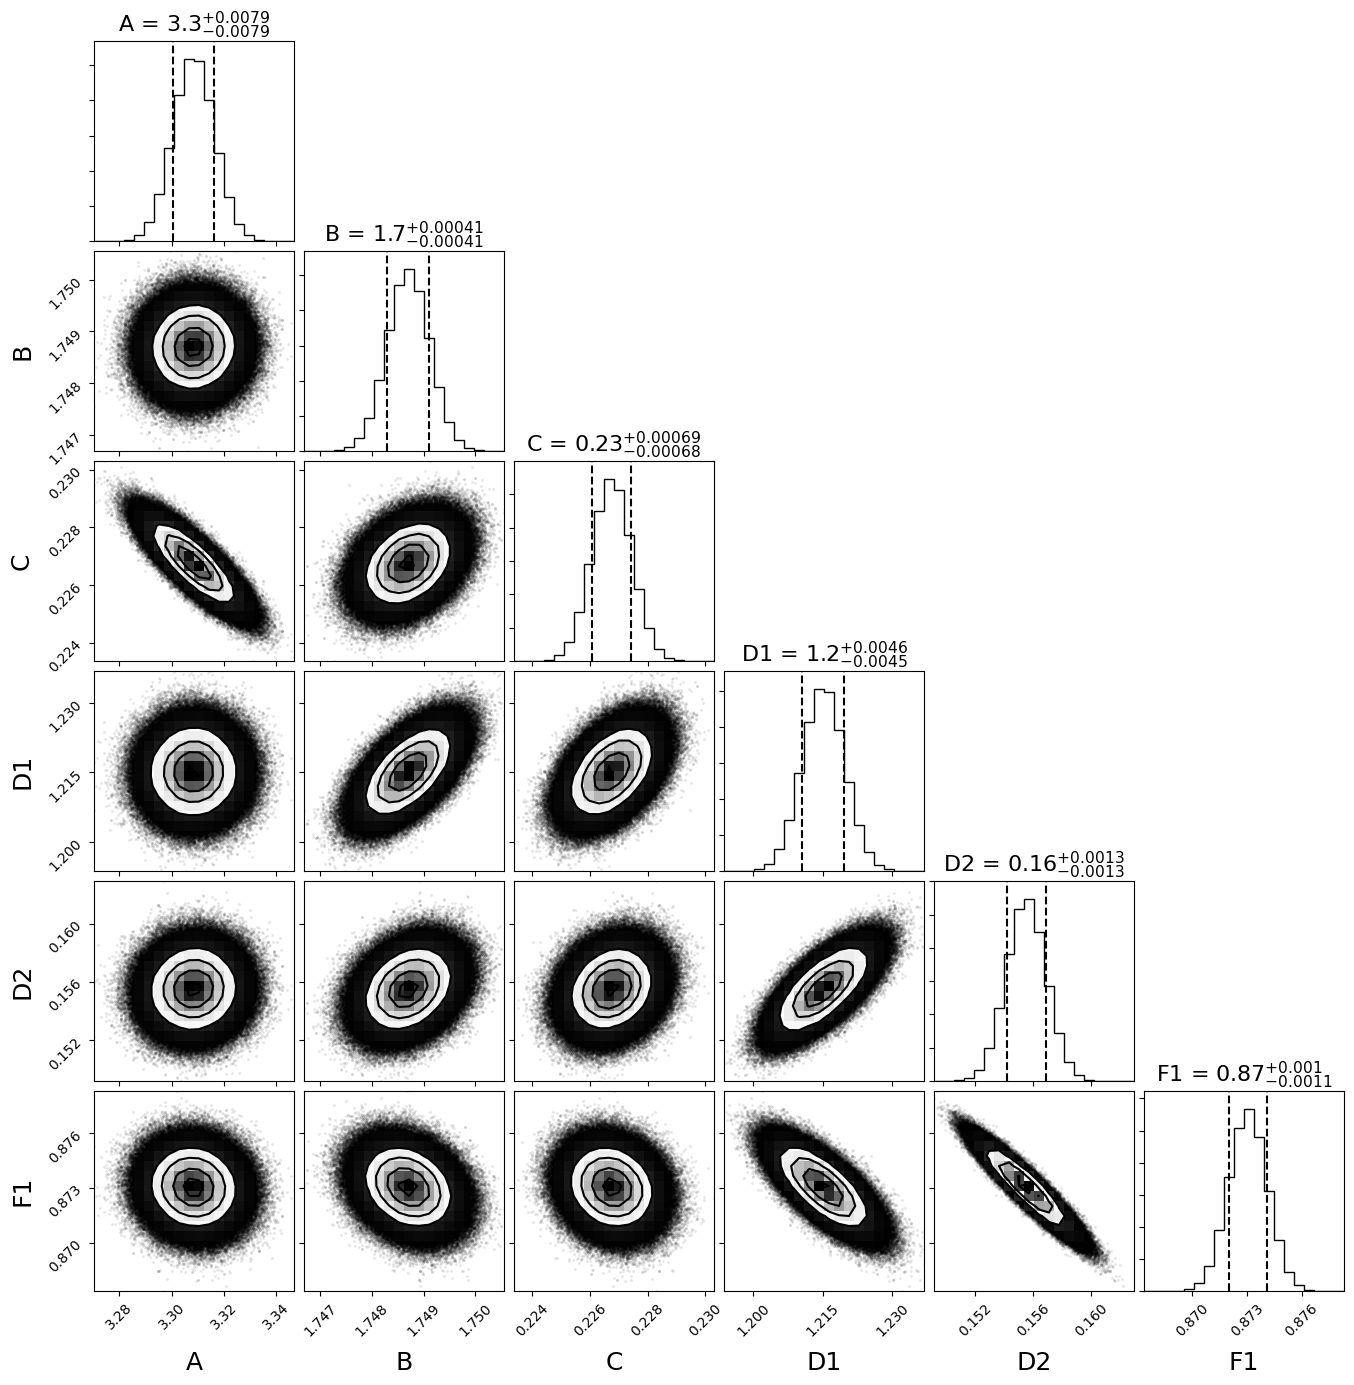

In [92]:
fig = corner.corner(
    mcmc_sampler, labels=labels2,label_kwargs={"fontsize":18},show_titles=True,quantiles=[0.16, 0.84], title_kwargs={"fontsize": 16},
    max_n_ticks=4,title_fmt=".2"
);

In [89]:

print("Mean acceptance fraction: {0:.3f}"
.format(np.mean(sampler2.acceptance_fraction)))

for i in range(ndim2):
    mcmc2 = np.percentile(flat_samples2[:, i], [16, 50, 84])
    q2 = np.diff(mcmc2)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    #print(mcmc2[1], q2[0], q2[1], labels2[i])
    #print(txt)
    txt = txt.format(mcmc2[1], q2[0], q2[1], labels2[i])
    display(Math(txt))

Mean acceptance fraction: 0.516


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [90]:

print("Mean acceptance fraction: {0:.3f}"
.format(np.mean(sampler2.acceptance_fraction)))

for i in range(ndim2):
    mcmc2 = np.percentile(flat_samples2[:, i], [16, 50, 84])
    q2 = np.diff(mcmc2)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = print(mcmc2[1], q2[0], q2[1], labels2[i])
    print(txt)
    #display(Math(txt))
    
#[18.012482847017512,1.972068713306366,0.044908682424470825,6.536339731685045,0.9387724469269554,0.6183448164959743]

Mean acceptance fraction: 0.516
3.3084171764154267 0.00785354283951456 0.007872594943000077 A
None
1.7487006442129847 0.0004061011094411704 0.00040676211820667163 B
None
0.22675566909557227 0.0006844468254868508 0.0006857184113158443 C
None
1.2150661012543313 0.0045430683976426245 0.004560801942592008 D1
None
0.15551877466066583 0.0013480249444665637 0.0013492634077481303 D2
None
0.8730412589198003 0.0010548119353191998 0.0010498759455777051 F1
None


In [ ]:
#[3.6281105426668883,1.7500017640073082,0.2035997267409103,1.3548846737678661,0.179091454739574,0.8107078443451485]

In [91]:
print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler2.get_autocorr_time())
    )
)

Mean autocorrelation time: 117.411 steps


In [194]:
print(np.median(flat_samples2,axis=0))
#previous mcmc values with V0 vetted flares [ 3.71476607 1.74966564 0.19791317 0.17912993 1.35912762 0.19600454]

[3.62811054 1.75000176 0.20359973 1.35488467 0.17909145 0.81070784]


Note: previous mcmc values with V0 vetted flares [ 3.4088527   3.7477446  -0.21710297  0.16109175  1.35048381  0.18575378] and an acceptance rate of 0.510

Text(0, 0.5, 'Relative Flux')

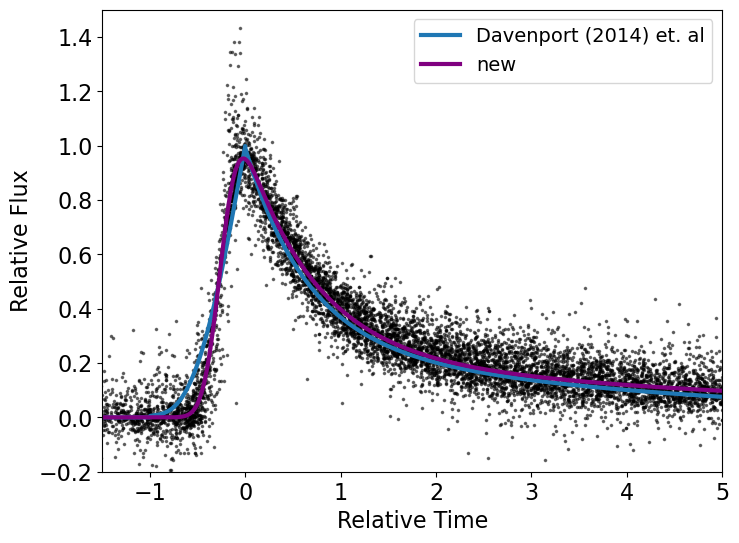

In [289]:
#shift things to be aligned at 0

plt.figure(figsize=(8, 6))
font = {'size'   : 16}
plt.rc('font', **font)
plt.plot(fit_time[fit_sort],aflare1(fit_time,0,1,1)[fit_sort],color='C0',label='Davenport (2014) et. al',lw=3)
#plt.plot(fit_time[fit_sort],jim_model[fit_sort],color='black',label='Davenport (2014) et. al')
#plt.plot(time[ns_all],jackman2(time,(3.71476607, 1.74966564, 0.19791317, 0.17912993, 1.35912762, 0.19600454))[ns_all],label='fit_vals',color='orange',lw=3)

plt.plot(fit_time[fit_sort],jackman2(fit_time,(3.6281105426668883,1.7500017640073082,0.2035997267409103,1.3548846737678661,0.179091454739574,0.8107078443451485))[fit_sort],label='new',color='purple',lw=3)
#plt.plot(time[ns_all],jackman2(time,(0.91780987, 1.72326426, 0.25978216, 0.81791936, 72.63673096, 2.76862114))[ns_all],label='Jims vals',color='orange')
plt.scatter(fit_time[fit_sort],fit_flux[fit_sort],alpha=0.5,s=10,marker='.',color='black')
#plt.xlim(-4,5)
plt.ylim(-0.2,1.5)
plt.xlim(-1.5,5)
plt.legend(loc='upper right',fontsize=14)
plt.xlabel('Relative Time')
plt.ylabel('Relative Flux')
#plt.savefig('/Users/lupitatovar/local_flares/figures/new_stack_procedure_comparison2.pdf')

In [1]:

# plot this into notebook to plot samples from posterior distribution
inds = np.random.randint(len(flat_samples2), size=100)
for ind in inds:
    sample = flat_samples2[ind]
    plt.plot(fit_time[fit_sort]+2, jackman2(fit_time[fit_sort]+2, [*sample]), "k", alpha=0.1)
    plt.xlabel('Relative Time')
    plt.ylabel('Relative Flux')

NameError: name 'np' is not defined

### Flare Model Version 2

In [293]:
def flare_model_v2(t,tpeak, fwhm, ampl, upsample=False, uptime=10):

    t_new = (t-tpeak)/fwhm +2


    #Values were fit & calculated using MCMC 256 walkers and 30000 steps

    A,B,C,D1,D2,f1 = [3.6281105426668883,1.7500017640073082,0.2035997267409103,1.3548846737678661,0.179091454739574,0.8107078443451485]
    #[18.012482847017512,1.972068713306366,0.044908682424470825,6.536339731685045,0.9387724469269554,0.6183448164959743]
    #[3.714766073353358,1.749665640328046,0.1979131664366433,0.17912992867648345,1.3591276162814818,0.19600454472080225]
         #short version [3.71476607, 1.74966564, 0.19791317, 0.17912993, 1.35912762, 0.19600454]
        #old numbers [3.09376901,  3.74111441, -0.24209949,  0.11042946,  1.32430633,  0.17351056]
    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    
    if upsample:
        dt = np.nanmedian(np.diff(np.abs(t_new)))
        timeup = np.linspace(min(t_new)-dt, max(t_new)+dt, t_new.size * uptime)

        flareup = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-timeup)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (timeup/C))))
                                                 + (f2 * np.exp((D2*(B-timeup)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (timeup/C)))))

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t_new-dt/2.,[max(t_new)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',bins=downbins)
    else:
        flare = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t_new)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t_new/C))))
                                             + (f2 * np.exp((D2*(B-t_new)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t_new/C)))))
        
    erf_bound = 0.5*(special.erf((t_new)*100) + 1)
    
    return flare * ampl * erf_bound 

Flare Model V1: Uses old stacking procedure and mcmc values from double_exp_emcee_fit1.ipynb

Flare Model V2: Vetting round 2 of flares, and new stacking procedure

Testing out new stacking procedure

Computing $\chi ^2$ of the data vs the new flare model below:

In [92]:
print(xmin)
print(xmax)
print(ymin)
print(ymax)

-1
5
-0.5
1.5


In [93]:
#both_mask_v2 = np.where((time[ns_all] > xmin) & (time[ns_all] < xmax) & (flux[ns_all] > ymin) & (flux[ns_all] < ymax))[0]
#print(len(both_mask_v2))

13324


In [120]:
#ymin = -0.5
#ymax= 1.5

both_mask = np.where((time[ns_all] > xmin) & (time[ns_all] < xmax) & (flux[ns_all] > ymin) & (flux[ns_all] < ymax))[0]
print(len(both_mask))
both_mask

13324


array([  193,   194,   195, ..., 13515, 13516, 13517])

In [295]:
both_mask_fit = np.where((fit_time[fit_sort] > xmin) & (fit_time[fit_sort] < xmax) & (fit_flux[fit_sort] > ymin) & (fit_flux[fit_sort] < ymax))[0]

In [296]:
print(len(fit_time))
print(len(time))

13421
13932


In [200]:
#Flare Model V1 with final round of vetted flares (414)
v1_f1 =(np.nansum(((flux[ns_all][both_mask]- flare_model(time[ns_all],0,1,1)[both_mask])/both_errors[ns_all][both_mask])**2)/(len(both_mask)))
print('Chi Squared Flare Model V1 with final vetting of flares: ' + str(v1_f1))

Chi Squared Flare Model V1 with final vetting of flares: 188.15122303046036


In [ ]:
#Flare Model V1 with round 2 of vetted flares (302)
#v1_f2 = (np.nansum(((flux_v2[v2_sort][both_mask_v2]- flare_model(time_v2[v2_sort],0,1,1.2)[both_mask_v2])/both_errors_v2[v2_sort][both_mask_v2])**2)/(len(both_mask_v2)))
#print('Chi Squared Flare Model V1 with Rd2 vetting of flares: ' + str(v1_f2))

In [201]:
#Flare Model V2 with final round of vetted flares (414)
v2_f2 = (np.nansum(((flux[ns_all][both_mask]- flare_model_v2(time[ns_all],0,1,1)[both_mask])/both_errors[ns_all][both_mask])**2)/(len(both_mask)))
print('Chi Squared Flare Model V2 new stacking procedure: ' + str(v2_f2))

Chi Squared Flare Model V2 new stacking procedure: 41.0589404747368


In [297]:
v1_fit = (np.nansum(((fit_flux[fit_sort][both_mask_fit]- flare_model(fit_time[fit_sort],0,1,1)[both_mask_fit])/fit_both_errors[fit_sort][both_mask_fit])**2)/(len(both_mask_fit)))
print('Chi Squared Flare Model V1 new stacking procedure, fit values: ' + str(v1_fit))

v2_fit = (np.nansum(((fit_flux[fit_sort][both_mask_fit]- flare_model_v2(fit_time[fit_sort],0,1,1)[both_mask_fit])/fit_both_errors[fit_sort][both_mask_fit])**2)/(len(both_mask_fit)))
print('Chi Squared Flare Model V2 new stacking procedure, fit values: ' + str(v2_fit))



Chi Squared Flare Model V1 new stacking procedure, fit values: 24832881401.878998
Chi Squared Flare Model V2 new stacking procedure, fit values: 19468703968.960762


## Rolling Median of final Vetted Flares

Text(0, 0.5, 'Relative Flux')

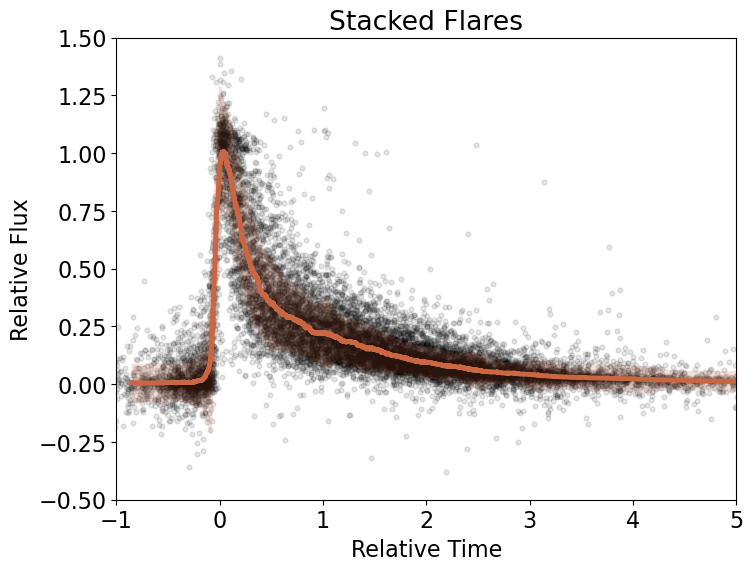

In [125]:
new_sort2 = np.argsort(x_all_final)
median2=pd.Series(y_all_final[new_sort2]).rolling(501, center=True).median()
standard_dev2 = pd.Series(y_all_final[new_sort2]).rolling(501, center=True).std()


fig, axs = plt.subplots(1,1, figsize=(8,6), facecolor='w', edgecolor='k')


axs.scatter(x_all_final[new_sort2],y_all_final[new_sort2],color='k',alpha=0.1,s=12)



axs.plot(x_all_final[new_sort2],median2,color='#ca6641',lw=3.5)

axs.fill_between(x_all_final[new_sort2], median2+standard_dev2, median2-standard_dev2,color='#ca6641', alpha=0.2,
                 edgecolor="none")

#axs[1].plot(x_all_final[new_sort2],np.cumsum(y_all_final[new_sort2])/np.sum(y_all_final[new_sort2]),color='k',alpha=0.5)



    #Axes limits
axs.set_xlim(-1,5)
axs.set_ylim(-0.5,1.5) 
    
#axs[1].set_xlim(-2,5)
#axs[1].set_ylim(-.5,1.5)


    #Setting Titles
axs.set_title('Stacked Flares')
#axs[1].set_title('Cumulative Distribution')
    

    #Axes labels
axs.set_xlabel("Relative Time",fontsize=16)
axs.set_ylabel("Relative Flux",fontsize=16)    
#axs[1].set_ylabel("Cummulative Flux",fontsize=16)
#axs[1].set_xlabel("Relative Time",fontsize=16)


    #Legend
    #ax1.legend(loc='lower right')


In [126]:
chi2_med2 = np.sum(((flux[ns_all][both_mask]- median2[both_mask])/both_errors[ns_all][both_mask])**2)/(len(both_mask))
print('Chi Squared of rolling median of final vet:' +str(chi2_med2))   

Chi Squared of rolling median of final vet:42.78679314593565


## Rolling Median of fit flares

Text(0, 0.5, 'Relative Flux')

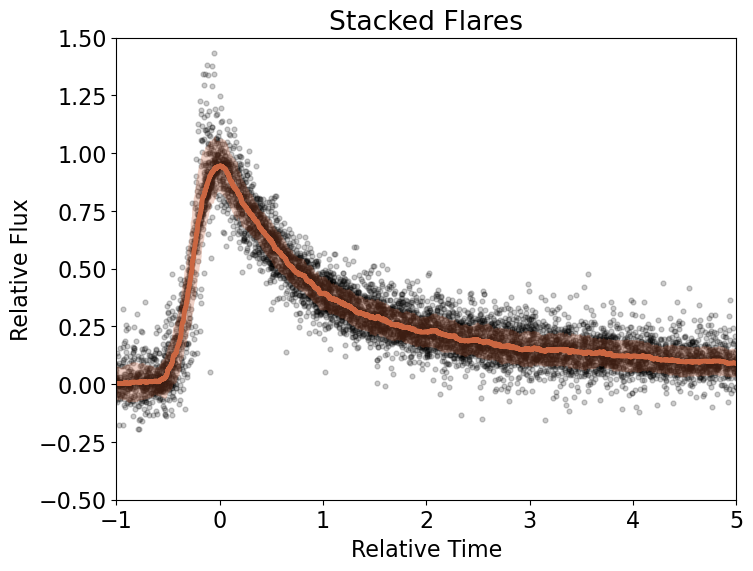

In [298]:

median_fit=pd.Series(fit_flux[fit_sort]).rolling(200, center=True).median()
standard_dev_fit = pd.Series(fit_flux[fit_sort]).rolling(200, center=True).std()


fig, axs = plt.subplots(1,1, figsize=(8,6), facecolor='w', edgecolor='k')


axs.scatter(fit_time[fit_sort],fit_flux[fit_sort],color='k',alpha=0.2,s=12)



axs.plot(fit_time[fit_sort],median_fit,color='#ca6641',lw=3.5)

axs.fill_between(fit_time[fit_sort], median_fit+standard_dev_fit, median_fit-standard_dev_fit,color='#ca6641', alpha=0.3,
                 edgecolor="none")




    #Axes limits
axs.set_xlim(-1,5)
axs.set_ylim(-0.5,1.5) 



    #Setting Titles
axs.set_title('Stacked Flares')

    

    #Axes labels
axs.set_xlabel("Relative Time",fontsize=16)
axs.set_ylabel("Relative Flux",fontsize=16)    


    #Legend
    #ax1.legend(loc='lower right')


In [219]:
median_fit.values

array([nan, nan, nan, ..., nan, nan, nan])

In [204]:

chi2_med2 = np.sum(((flux[ns_all][both_mask]- median2[both_mask])/both_errors[ns_all][both_mask])**2)/(len(both_mask))
print('Chi Squared of rolling median of final vet:' +str(chi2_med2))   

chi2_fitmed = np.sum(((fit_flux[fit_sort][both_mask_fit]- median_fit[both_mask_fit])/fit_both_errors[fit_sort][both_mask_fit])**2)/(len(both_mask_fit))
print('Chi Squared of rolling median of final vet:' +str(chi2_fitmed))




Chi Squared of rolling median of final vet:42.78679314593565
Chi Squared of rolling median of final vet:19521811322.89807


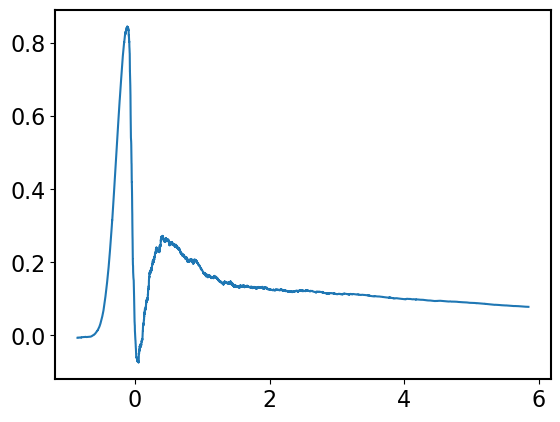

In [217]:
plt.plot(time[ns_all],flare_model_v2(time,0,1,1)[ns_all]-median2)
#plt.scatter(fit_time[fit_sort],flare_model_v2(fit_time,0,1,1)[fit_sort]-median_fit,s=5)

In [ ]:
from scipy import special
def ModifiedGaussian(t,A,mu,sigma,tau):
        x = 1./(2.*tau) * np.exp(.5*(sigma/tau)**2) * np.exp(- (t-mu)/tau)
        s = A*x*( 1. + special.erf((t-mu-sigma**2/tau)/np.sqrt(2*sigma**2)))
        return s


New figures

In [ ]:
rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 4]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ['Verdana']#["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

## Original 2014 stack of flares with '14 model and jackman param model overlay
(This plot is before we vetted the flares and prior to an updated stack procedure)

Text(0, 0.5, 'Relative Flux')

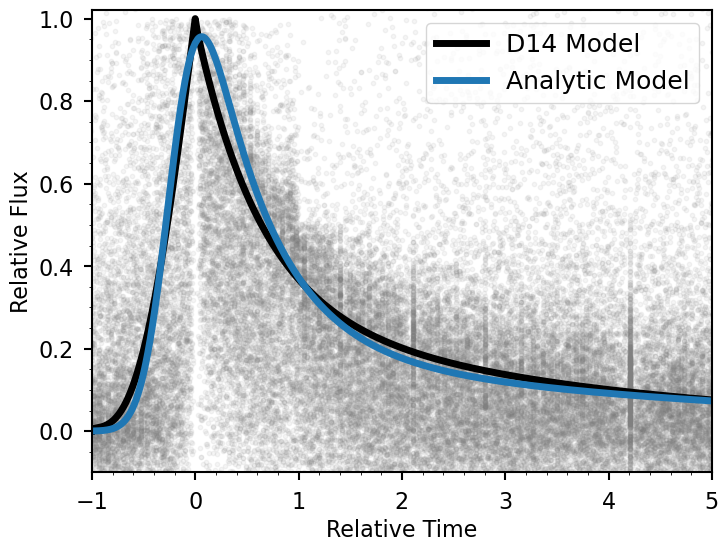

In [299]:
plt.figure(figsize=(8, 6))
plt.rcParams['axes.linewidth']=1.5
plt.tick_params(direction='out',width=1.5,length=6,pad=7)
plt.minorticks_on()

########### Latest Stack of Vetted Flares ############
#plt.plot(time_v2[v2_sort],aflare1(time_v2,0,1,1)[v2_sort],color='black',label='D14 Model',lw=3)
#plt.plot(time_v2[v2_sort]-2,flare_model_v2(time_v2,0,1,1)[v2_sort],label='Analytic Model',color='chocolate',lw=3)
#plt.plot(time_v2[v2_sort]-2,flare_model(time_v2,0,1,1)[v2_sort],label='Analytic Model',color='chocolate',lw=3)
#plt.plot(time_v2[v2_sort],ModifiedGaussian(time_v2,1.496,-0.276,-0.183,1.222)[v2_sort],label='Single Exp',color='darkmagenta',lw=3)
#plt.scatter(fit_time2[fit_sort2]-2,fit_flux2[fit_sort2],alpha=.3,s=10,marker='.',color='grey')


############# D14 stack ######################
plt.plot(old_time[os_sort],aflare1(old_time,0,1,1)[os_sort],color='black',label='D14 Model',lw=5)
plt.plot(old_time[os_sort],flare_model(old_time,0,1,1)[os_sort],label='Analytic Model',color='C0',lw=5)
plt.scatter(old_time[os_sort],old_stack['flux'][os_sort],color='grey',alpha=0.08,s=10)
#plt.xlim(-4,5)
plt.ylim(-0.1,1.02)
plt.xlim(-1,5)
plt.legend(loc='upper right',fontsize=18)
plt.xlabel('Relative Time')
plt.ylabel('Relative Flux')
#plt.savefig('/Users/lupitatovar/local_flares/figures/2_model_comparison_wdata.png',bbox_inches='tight')

## Old stacking procedure model comparison

Text(0, 0.5, 'Relative Flux')

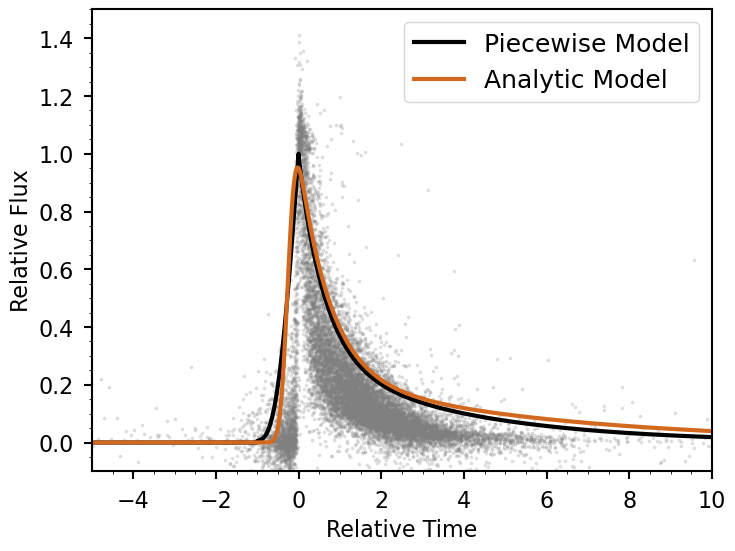

In [300]:
plt.figure(figsize=(8, 6))
plt.rcParams['axes.linewidth']=1.5
plt.tick_params(direction='out',width=1.5,length=6,pad=7)
plt.minorticks_on()

plt.plot(time[ns_all],aflare1(time,0,1,1)[ns_all],color='black',label='Piecewise Model',lw=3)
plt.plot(time[ns_all],flare_model_v2(time,0,1,1)[ns_all],label='Analytic Model',color='chocolate',lw=3)
#plt.plot(time_v2[v2_sort],ModifiedGaussian(time_v2,1.496,-0.276,-0.183,1.222)[v2_sort],label='Single Exp',color='darkmagenta',lw=3)
plt.scatter(time[ns_all],flux[ns_all],alpha=.18,s=12,marker='.',color='grey')
#plt.xlim(-4,5)
plt.ylim(-0.1,1.5)
plt.xlim(-5,10)
plt.legend(loc='upper right',fontsize=18)
plt.xlabel('Relative Time')
plt.ylabel('Relative Flux')
#plt.savefig('/Users/lupitatovar/local_flares/figures/new_model_vet2_model_overlay.png',bbox_inches='tight')

## Updated stacking procedure model comparison

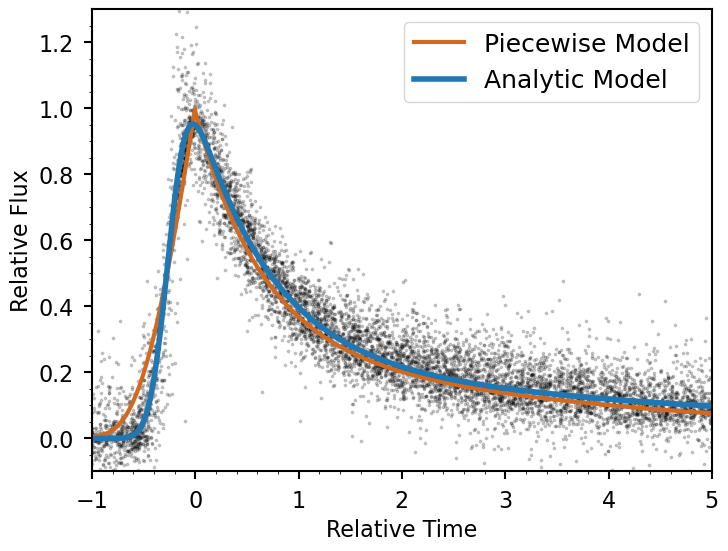

In [304]:
plt.figure(figsize=(8, 6))
plt.rcParams['axes.linewidth']=1.5
plt.tick_params(direction='out',width=1.5,length=6,pad=7)
plt.minorticks_on()

plt.plot(fit_time[fit_sort],aflare1(fit_time,0,1,1)[fit_sort],color='chocolate',label='Piecewise Model',lw=3)
plt.plot(fit_time[fit_sort],flare_model_v2(fit_time,0,1,1)[fit_sort],label='Analytic Model',color='C0',lw=4)
#plt.plot(time_v2[v2_sort],ModifiedGaussian(time_v2,1.496,-0.276,-0.183,1.222)[v2_sort],label='Single Exp',color='darkmagenta',lw=3)
plt.scatter(fit_time[fit_sort],fit_flux[fit_sort],alpha=.18,s=12,marker='.',color='k')
#plt.xlim(-4,5)
plt.ylim(-0.1,1.3)
plt.xlim(-1,5)
plt.legend(loc='upper right',fontsize=18)
plt.xlabel('Relative Time')
plt.ylabel('Relative Flux')
#plt.savefig('/Users/lupitatovar/local_flares/figures/final_model_comparisons.png',bbox_inches='tight')

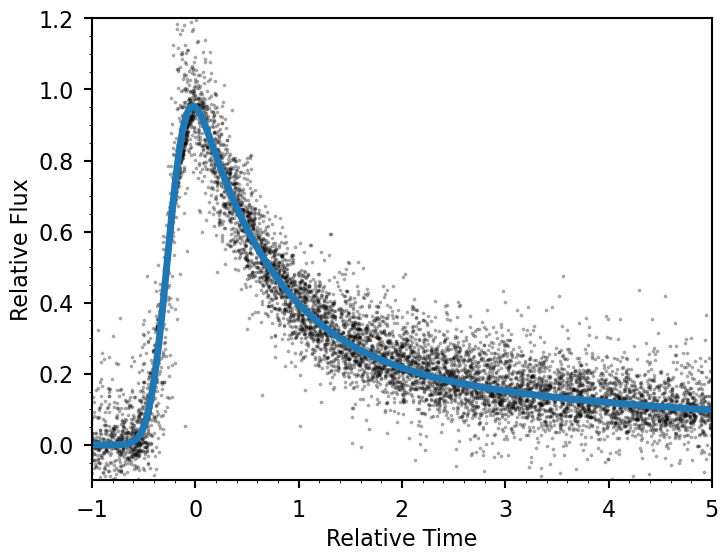

In [306]:
plt.figure(figsize=(8, 6))
plt.rcParams['axes.linewidth']=1.5
plt.tick_params(direction='out',width=1.5,length=6,pad=7)
plt.minorticks_on()

#plt.plot(fit_time[fit_sort],aflare1(fit_time,0,1,1)[fit_sort],color='chocolate',label='Piecewise Model',lw=3)
plt.plot(fit_time[fit_sort],flare_model_v2(fit_time,0,1,1)[fit_sort],label='Analytic Model',color='C0',lw=5)
#plt.plot(time_v2[v2_sort],ModifiedGaussian(time_v2,1.496,-0.276,-0.183,1.222)[v2_sort],label='Single Exp',color='darkmagenta',lw=3)
plt.scatter(fit_time[fit_sort],fit_flux[fit_sort],alpha=.25,s=12,marker='.',color='k')
#plt.xlim(-4,5)
plt.ylim(-0.1,1.2)
plt.xlim(-1,5)
#plt.legend(loc='upper right',fontsize=18)
plt.xlabel('Relative Time')
plt.ylabel('Relative Flux')
#plt.savefig('/Users/lupitatovar/local_flares/figures/final_kepler_model.png',bbox_inches='tight')

In [125]:
print(len(flux))
print(len(fit_flux))

13932
13421


In [ ]:
#fit_time2 = fit_flare_vals2['time'].values
#fit_flux2 = fit_flare_vals2['flux'].values
#fit_flux_err2 = fit_flare_vals2['flux_err'].values
#fit_gp_err2 = fit_flare_vals2['gp_st_dev'].values

#fit_both_errors2 = np.sqrt( (fit_flux_err2)**2 + (fit_gp_err2)**2 )


In [ ]:
print(df['mean'].values)
print(df['std'].values)
print(fit_flux_err2)
print(fit_gp_err2)

In [ ]:
#plotting the residuals
#plt.plot(fit_both_errors2[fit_sort2])
#plt.ylim(-0.1,1.2)
#plt.xlim(0,100)

#plt.plot(fit_time2[fit_sort2], fit_flux2[fit_sort2],alpha=0.9)
#plt.plot(fit_time2[fit_sort2], fit_both_errors2[fit_sort2])
#plt.fill_between(fit_time2, fit_flux_err2+fit_gp_err2, fit_flux_err2-fit_gp_err2,color=color, alpha=1,
                 #edgecolor="none",label='err')

plt.xlim(-1,20)

Text(0.5, 1.0, 'Cumulative Distribution')

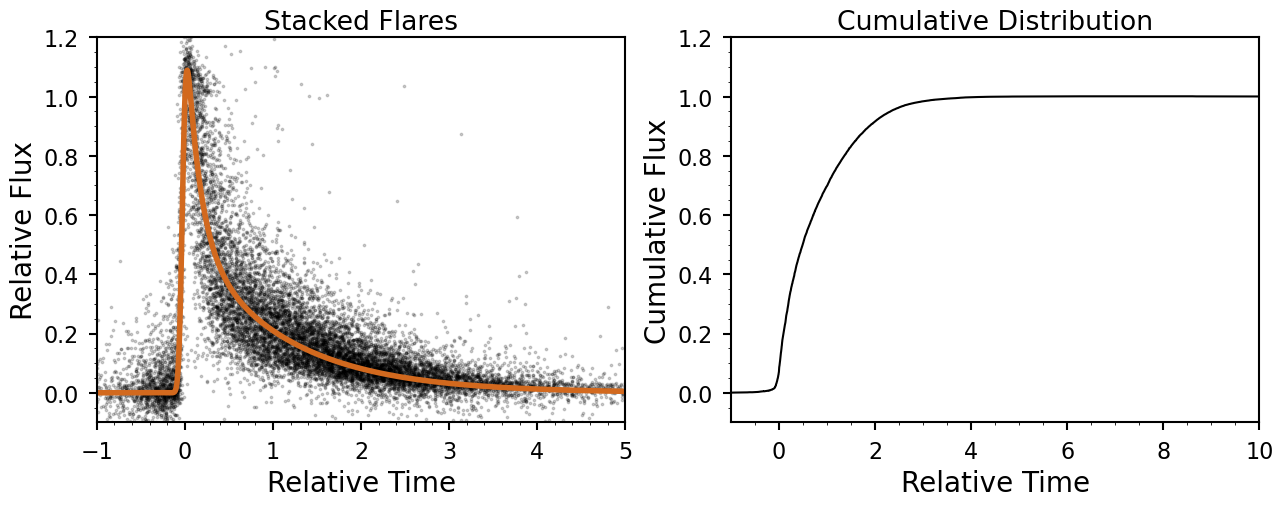

In [128]:
fig, axs = plt.subplots(1,2, figsize=(15, 5), facecolor='w', edgecolor='k')
plt.rcParams['axes.linewidth']=1.5
axs[0].tick_params(direction='out',width=1.5,length=6,pad=7)
axs[1].tick_params(direction='out',width=1.5,length=6,pad=7)
axs[0].minorticks_on()
axs[1].minorticks_on()

#plt.plot(time_v2[v2_sort],aflare1(time_v2,0,1,1)[v2_sort],color='black',label='Piecewise Model',lw=3)
axs[0].plot(time[ns_all],flare_model_v2(time,0,1,1)[ns_all],label='Analytic Model',color='chocolate',lw=4)
#plt.plot(time_v2[v2_sort],ModifiedGaussian(time_v2,1.496,-0.276,-0.183,1.222)[v2_sort],label='Single Exp',color='darkmagenta',lw=3)
axs[0].scatter(time[ns_all],flux[ns_all],alpha=.18,s=12,marker='.',color='k')


axs[1].plot(time[ns_all],np.cumsum(flux[ns_all])/np.sum(flux[ns_all]),color='k')

#plt.legend(loc='upper right',fontsize=18)


axs[0].set_xlim(-1,5)
axs[0].set_ylim(-0.1,1.2)
axs[0].set_xlabel('Relative Time',fontsize=20)
axs[0].set_ylabel('Relative Flux',fontsize=20)
axs[0].set_title('Stacked Flares')

axs[1].set_xlim(-1,10)
axs[1].set_ylim(-0.1,1.2)
axs[1].set_xlabel('Relative Time',fontsize=20)
axs[1].set_ylabel('Cumulative Flux',fontsize=20)
axs[1].set_title('Cumulative Distribution')

#plt.savefig('/Users/lupitatovar/local_flares/figures/new_model_vet2_cu_dist.png',bbox_inches='tight')
